In [6]:
# **TABLE OCR PROCESSING PIPELINE**

##  **Overview - Tổng quan**
#**Pipeline xử lý OCR bảng với YOLO detection + Advanced OCR**

### **Pipeline Structure:**
#1. **CELL 1-2**: **Setup & Model Loading** (PyTorch patch + YOLO model)
#2. **CELL 3**:  **Table Detection** (Detect rows, columns, cells)  
#3. **CELL 4**:  **Visualization** (Show detection results)
#4. **CELL 5**:  **Basic OCR Setup** (Initialize OCR engines)
#5. **CELL 6**:  **Basic Cell Processing** (Crop cells + basic OCR)
#6. **CELL 7**:  **Save Basic Results** (JSON, CSV outputs)
#7. **CELL 8**:  **Advanced OCR Engine** (Multi-method enhanced OCR)
#8. **CELL 9**:  **Enhanced Processing** (Advanced cell processing)
#9. **CELL 10**: **Final Results** (Structured table + comparison)

###  **Key Output Files:**
#- `table_detections.json` - Raw YOLO detection results  
#- `detected_table.png` - Visualization with bounding boxes
#- `enhanced_structured_table.csv` - **Final structured table** 
#- `final_enhanced_results.json` - Complete enhanced dataset
#- `improvement_report.txt` - Human-readable improvement metrics

#---
import torch
import warnings
import os
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image
import json

# PyTorch 2.7 Compatibility Fix
warnings.filterwarnings("ignore", category=FutureWarning)

original_torch_load = torch.load
def patched_torch_load(f, map_location=None, pickle_module=None, weights_only=None, **kwargs):
    try:
        return original_torch_load(f, map_location=map_location, 
                                 pickle_module=pickle_module, 
                                 weights_only=True, **kwargs)
    except Exception:
        print("⚠️  Fallback: Loading with weights_only=False for compatibility")
        return original_torch_load(f, map_location=map_location, 
                                 pickle_module=pickle_module, 
                                 weights_only=False, **kwargs)
torch.load = patched_torch_load
print("✅ PyTorch compatibility patch applied")


✅ PyTorch compatibility patch applied


In [7]:
# CELL 1: 🔧 PYTORCH SETUP & COMPATIBILITY PATCH
print("🔧 CELL 1: PyTorch Setup & Compatibility")

import torch
import warnings
import os
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image
import json

# PyTorch 2.7+ Compatibility Fix
warnings.filterwarnings("ignore", category=FutureWarning)

# Backup original torch.load if not already done
if not hasattr(torch, 'original_load_backup'):
    torch.original_load_backup = torch.load
    print("💾 Backed up original torch.load")

def safe_torch_load(f, map_location=None, pickle_module=None, weights_only=None, **kwargs):
    """Safe torch.load với fallback cho older models"""
    try:
        # Try weights_only=True first (PyTorch 2.7+ security)
        return torch.original_load_backup(f, map_location=map_location,
                                         pickle_module=pickle_module,
                                         weights_only=True, **kwargs)
    except Exception:
        # Fallback to weights_only=False (for older YOLO models)
        return torch.original_load_backup(f, map_location=map_location,
                                         pickle_module=pickle_module,
                                         weights_only=False, **kwargs)

# Apply safe patch
torch.load = safe_torch_load
print("✅ PyTorch compatibility patch applied successfully")


🔧 CELL 1: PyTorch Setup & Compatibility
💾 Backed up original torch.load
✅ PyTorch compatibility patch applied successfully


In [8]:
# CELL 2: 🔍 YOLO MODEL LOADING & TABLE STRUCTURE DETECTOR
print("🔍 CELL 2: YOLO Model Loading & Table Structure Detector")

class TableStructureDetector:
    """Advanced Table Structure Detection using custom YOLOv8 model"""
    
    def __init__(self, model_path: str):
        print(f"🔄 Loading YOLO model: {model_path}")
        try:
            if os.path.exists(model_path):
                self.model = YOLO(model_path)
                print(f"✅ Custom model loaded: {model_path}")
            else:
                print(f"❌ Model file not found: {model_path}")
                print("🔄 Loading YOLOv8 pre-trained model instead...")
                self.model = YOLO('yolov8n.pt')
                print("✅ YOLOv8 pre-trained model loaded")
        except Exception as e:
            print(f"❌ Error loading model: {e}")
            print("🔄 Fallback to YOLOv8 pre-trained model...")
            self.model = YOLO('yolov8n.pt')
            print("✅ YOLOv8 pre-trained model loaded (fallback)")
    
    def detect_table_structure(self, image_path: str, confidence_threshold: float = 0.5):
        """Detect table structure: rows, columns, cells, tables"""
        print(f"🔍 Analyzing table structure in: {image_path}")
        
        # Load image
        if isinstance(image_path, str):
            image = cv2.imread(image_path)
            if image is None:
                print(f"❌ Could not load image: {image_path}")
                return None, None, None
        else:
            image = image_path
        
        print(f"📸 Image shape: {image.shape}")
        
        # Run YOLO detection
        results = self.model(image, conf=confidence_threshold)
        
        # Initialize detection containers
        detections = {
            'rows': [],
            'columns': [],
            'cells': [],
            'tables': [],
            'other': []
        }
        
        class_counts = {}
        
        # Process detection results
        for result in results:
            boxes = result.boxes
            if boxes is not None:
                for box in boxes:
                    # Extract box data
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                    confidence = box.conf[0].cpu().numpy()
                    class_id = int(box.cls[0].cpu().numpy())
                    
                    # Get class name
                    class_name = self.model.names[class_id] if class_id in self.model.names else f"class_{class_id}"
                    class_counts[class_name] = class_counts.get(class_name, 0) + 1
                    
                    # Create detection info with consistent field names
                    bbox = [int(x1), int(y1), int(x2), int(y2)]
                    detection_info = {
                        'bbox': bbox,
                        'confidence': float(confidence),  # ✅ Use 'confidence' consistently
                        'class_name': class_name,
                        'class_id': class_id
                    }
                    
                    # Categorize detections by class
                    if 'row' in class_name.lower() or class_id == 0:
                        detections['rows'].append(detection_info)
                    elif 'column' in class_name.lower() or class_id == 1:
                        detections['columns'].append(detection_info)
                    elif 'cell' in class_name.lower() or class_id == 2:
                        detections['cells'].append(detection_info)
                    elif 'table' in class_name.lower() or class_id == 3:
                        detections['tables'].append(detection_info)
                    else:
                        detections['other'].append(detection_info)
        
        # Print detection summary
        print(f"🔍 Detection Summary:")
        print(f"   📊 Classes found: {class_counts}")
        print(f"   📏 Rows: {len(detections['rows'])}")
        print(f"   📋 Columns: {len(detections['columns'])}")
        print(f"   🔲 Cells: {len(detections['cells'])}")
        print(f"   🏗️ Tables: {len(detections['tables'])}")
        print(f"   ❓ Other: {len(detections['other'])}")
        
        return detections, image, class_counts

# Initialize detector
print("🚀 Initialized TableStructureDetector class")


🔍 CELL 2: YOLO Model Loading & Table Structure Detector
🚀 Initialized TableStructureDetector class


In [10]:
# CELL 3: 🎯 RUN TABLE DETECTION
print("🎯 CELL 3: Running Table Detection")

def run_table_detection():
    """Run table detection on the target image"""
    try:
        print("🧪 Testing Table Structure Detection...")
        
        # Initialize detector with your model
        model_path = r"C:\Users\CNTT\Desktop\cv\best.pt"
        detector = TableStructureDetector(model_path)
        
        # Run detection on your image  
        image_path = r"C:\Users\CNTT\Desktop\cv\test.png"
        detections, image, class_counts = detector.detect_table_structure(image_path)
        
        if detections:
            print("✅ Detection successful!")
            
            # Save detection results
            with open('table_detections.json', 'w') as f:
                json.dump({
                    'detections': detections,
                    'class_counts': class_counts,
                    'summary': {
                        'total_rows': len(detections['rows']),
                        'total_columns': len(detections['columns']),
                        'total_cells': len(detections['cells']),
                        'total_tables': len(detections['tables'])
                    }
                }, f, indent=2)
            print("💾 Results saved to table_detections.json")
            
            return detections, image, class_counts
        else:
            print("❌ No detections found")
            return None, None, None
            
    except Exception as e:
        print(f"❌ Detection failed: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

# Run detection
print("🚀 Starting Table Structure Detection...")
detection_result = run_table_detection()

if detection_result[0] is not None:
    detections, image, class_counts = detection_result
    print(f"✅ Detection completed successfully!")
    print(f"📊 Found: {len(detections['rows'])} rows, {len(detections['columns'])} columns, {len(detections['cells'])} cells")
else:
    print("❌ Detection failed - check your model and image paths")


🎯 CELL 3: Running Table Detection
🚀 Starting Table Structure Detection...
🧪 Testing Table Structure Detection...
🔄 Loading YOLO model: C:\Users\CNTT\Desktop\cv\best.pt
⚠️  Fallback: Loading with weights_only=False for compatibility
✅ Custom model loaded: C:\Users\CNTT\Desktop\cv\best.pt
🔍 Analyzing table structure in: C:\Users\CNTT\Desktop\cv\test.png
📸 Image shape: (365, 817, 3)



0: 288x640 11 rows, 8 columns, 54.5ms
Speed: 3.0ms preprocess, 54.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)


🔍 Detection Summary:
   📊 Classes found: {'column': 8, 'row': 11}
   📏 Rows: 11
   📋 Columns: 8
   🔲 Cells: 0
   🏗️ Tables: 0
   ❓ Other: 0
✅ Detection successful!
💾 Results saved to table_detections.json
✅ Detection completed successfully!
📊 Found: 11 rows, 8 columns, 0 cells


🎨 CELL 4: Visualization & Detection Analysis
🎨 Visualizing detection results...
🎨 Creating visualization...
✅ Drew 19 detections
💾 Visualization saved to: detected_table.png


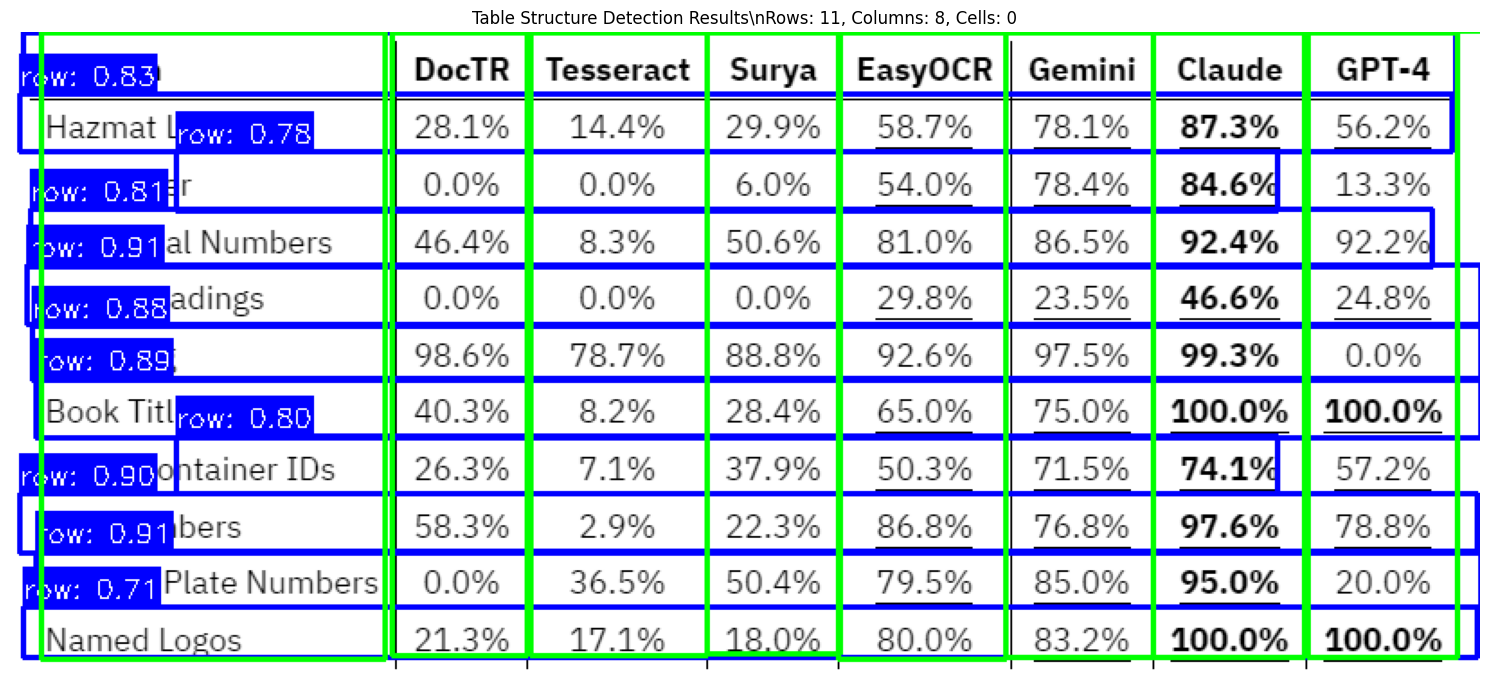

📊 Detection Quality Analysis:
   Rows:
     Count: 11
     Confidence - Avg: 0.842, Min: 0.707, Max: 0.913
   Columns:
     Count: 8
     Confidence - Avg: 0.887, Min: 0.798, Max: 0.931
\n📈 Overall Statistics:
   Total detections: 19
   Average confidence: 0.861
   Confidence range: 0.707 - 0.931
🎯 Visualization complete!


In [11]:
# CELL 4: 🎨 VISUALIZATION & DETECTION ANALYSIS
print("🎨 CELL 4: Visualization & Detection Analysis")

def visualize_table_detections(detections, image, save_path="detected_table.png"):
    """Visualize detected table structure with colored bounding boxes"""
    if detections is None or image is None:
        print("❌ No detections or image to visualize")
        return None
    
    print("🎨 Creating visualization...")
    
    # Create copy for drawing
    vis_image = image.copy()
    
    # Color scheme for different detection types
    colors = {
        'rows': (255, 0, 0),      # Red
        'columns': (0, 255, 0),   # Green  
        'cells': (0, 0, 255),     # Blue
        'tables': (255, 255, 0),  # Yellow
        'other': (255, 0, 255)    # Magenta
    }
    
    # Draw all detections
    total_drawn = 0
    for detection_type, detection_list in detections.items():
        color = colors.get(detection_type, (128, 128, 128))
        
        for detection in detection_list:
            bbox = detection['bbox']
            confidence = detection['confidence']
            class_name = detection['class_name']
            
            x1, y1, x2, y2 = bbox
            
            # Draw bounding box
            cv2.rectangle(vis_image, (x1, y1), (x2, y2), color, 2)
            
            # Prepare label
            label = f"{class_name}: {confidence:.2f}"
            label_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)[0]
            
            # Draw label background
            cv2.rectangle(vis_image, 
                         (x1, y1 - label_size[1] - 10), 
                         (x1 + label_size[0], y1), 
                         color, -1)
            
            # Draw label text
            cv2.putText(vis_image, label, (x1, y1 - 5), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
            
            total_drawn += 1
    
    print(f"✅ Drew {total_drawn} detections")
    
    # Save visualization
    cv2.imwrite(save_path, vis_image)
    print(f"💾 Visualization saved to: {save_path}")
    
    # Display with matplotlib
    plt.figure(figsize=(15, 10))
    plt.imshow(cv2.cvtColor(vis_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Table Structure Detection Results\\n" + 
              f"Rows: {len(detections['rows'])}, " +
              f"Columns: {len(detections['columns'])}, " +
              f"Cells: {len(detections['cells'])}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return vis_image

def analyze_detection_quality(detections):
    """Analyze detection quality and statistics"""
    print("📊 Detection Quality Analysis:")
    
    for detection_type, detection_list in detections.items():
        if detection_list:
            confidences = [d['confidence'] for d in detection_list]
            avg_conf = np.mean(confidences)
            min_conf = np.min(confidences)
            max_conf = np.max(confidences)
            
            print(f"   {detection_type.capitalize()}:")
            print(f"     Count: {len(detection_list)}")
            print(f"     Confidence - Avg: {avg_conf:.3f}, Min: {min_conf:.3f}, Max: {max_conf:.3f}")
    
    # Overall statistics
    total_detections = sum(len(detections[key]) for key in detections)
    print(f"\\n📈 Overall Statistics:")
    print(f"   Total detections: {total_detections}")
    
    if total_detections > 0:
        all_confidences = []
        for detection_list in detections.values():
            all_confidences.extend([d['confidence'] for d in detection_list])
        
        if all_confidences:
            print(f"   Average confidence: {np.mean(all_confidences):.3f}")
            print(f"   Confidence range: {np.min(all_confidences):.3f} - {np.max(all_confidences):.3f}")

# Run visualization if detection was successful
if 'detection_result' in globals() and detection_result[0] is not None:
    print("🎨 Visualizing detection results...")
    detections, image, class_counts = detection_result
    
    # Create visualization
    vis_image = visualize_table_detections(detections, image)
    
    # Analyze quality
    analyze_detection_quality(detections)
    
    print("🎯 Visualization complete!")
else:
    print("⚠️ No detection results to visualize. Run CELL 3 first.")


In [12]:
# CELL 5: 📝 MULTI-OCR ENGINE SETUP
print("📝 CELL 5: Multi-OCR Engine Setup")

import easyocr
import pytesseract
import warnings
try:
    from paddleocr import PaddleOCR
    PADDLEOCR_AVAILABLE = True
except ImportError:
    PADDLEOCR_AVAILABLE = False
    print("⚠️ PaddleOCR not available")

class MultiOCREngine:
    """Multi-OCR Engine with error handling and compatibility fixes"""
    
    def __init__(self):
        print("🔧 Initializing OCR engines...")
        warnings.filterwarnings("ignore", category=UserWarning)
        
        # EasyOCR initialization
        try:
            self.easyocr = easyocr.Reader(['en'], gpu=False)
            self.easyocr_available = True
            print("✅ EasyOCR initialized successfully")
        except Exception as e:
            print(f"⚠️ EasyOCR initialization failed: {e}")
            self.easyocr_available = False
        
        # Tesseract availability check
        try:
            pytesseract.get_tesseract_version()
            self.tesseract_available = True
            print("✅ Tesseract available")
        except Exception as e:
            print(f"⚠️ Tesseract not available: {e}")
            self.tesseract_available = False
        
        # PaddleOCR initialization
        if PADDLEOCR_AVAILABLE:
            try:
                self.paddleocr = PaddleOCR(lang='en', show_log=False)
                self.paddleocr_available = True
                print("✅ PaddleOCR initialized successfully")
            except Exception as e:
                print(f"⚠️ PaddleOCR initialization failed: {e}")
                self.paddleocr_available = False
        else:
            self.paddleocr_available = False
        
        # Report available engines
        available_engines = []
        if self.easyocr_available: available_engines.append("EasyOCR")
        if self.tesseract_available: available_engines.append("Tesseract")
        if self.paddleocr_available: available_engines.append("PaddleOCR")
        
        print(f"🎯 Available OCR engines: {', '.join(available_engines) if available_engines else 'None'}")
    
    def extract_text_easyocr(self, image):
        """Extract text using EasyOCR"""
        if not self.easyocr_available:
            return "", 0.0
        
        try:
            # Convert BGR to RGB if needed
            if len(image.shape) == 3 and image.shape[2] == 3:
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            else:
                image_rgb = image
            
            results = self.easyocr.readtext(image_rgb)
            
            if results:
                texts = []
                confidences = []
                for (bbox, text, confidence) in results:
                    if confidence > 0.3:  # Confidence threshold
                        texts.append(text)
                        confidences.append(confidence)
                
                if texts:
                    combined_text = ' '.join(texts)
                    avg_confidence = np.mean(confidences)
                    return combined_text, avg_confidence
            
            return "", 0.0
            
        except Exception as e:
            print(f"⚠️ EasyOCR error: {e}")
            return "", 0.0
    
    def extract_text_tesseract(self, image):
        """Extract text using Tesseract"""
        if not self.tesseract_available:
            return "", 0.0
        
        try:
            # Tesseract config for better results
            config = '--oem 3 --psm 6 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz.,-%()$€£¥ '
            
            # Get text with confidence
            data = pytesseract.image_to_data(image, config=config, output_type=pytesseract.Output.DICT)
            
            # Filter high confidence text
            texts = []
            confidences = []
            for i in range(len(data['text'])):
                if int(data['conf'][i]) > 30:
                    text = data['text'][i].strip()
                    if text:
                        texts.append(text)
                        confidences.append(int(data['conf'][i]))
            
            if texts:
                combined_text = ' '.join(texts)
                avg_confidence = np.mean(confidences) / 100.0  # Normalize to 0-1
                return combined_text, avg_confidence
            
            return "", 0.0
            
        except Exception as e:
            print(f"⚠️ Tesseract error: {e}")
            return "", 0.0
    
    def extract_text_paddleocr(self, image):
        """Extract text using PaddleOCR"""
        if not self.paddleocr_available:
            return "", 0.0
        
        try:
            from PIL import Image as PILImage
            
            if isinstance(image, np.ndarray):
                if len(image.shape) == 2:  # Grayscale
                    pil_image = PILImage.fromarray(image, mode='L')
                else:  # RGB/BGR
                    if image.shape[2] == 3:
                        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                        pil_image = PILImage.fromarray(image_rgb)
                    else:
                        pil_image = PILImage.fromarray(image)
            else:
                pil_image = image
            
            # Use PaddleOCR API
            results = self.paddleocr.ocr(np.array(pil_image))
            
            if results and results[0]:
                texts = []
                confidences = []
                for line in results[0]:
                    if len(line) >= 2 and len(line[1]) >= 2:
                        text = line[1][0]
                        conf = line[1][1]
                        if conf > 0.3:
                            texts.append(text)
                            confidences.append(conf)
                
                if texts:
                    combined_text = ' '.join(texts)
                    avg_confidence = np.mean(confidences)
                    return combined_text, avg_confidence
            
            return "", 0.0
            
        except Exception as e:
            print(f"⚠️ PaddleOCR error: {e}")
            return "", 0.0
    
    def best_ocr_result(self, image):
        """Get best OCR result from all available engines"""
        results = []
        
        # Try all available engines
        if self.easyocr_available:
            text, conf = self.extract_text_easyocr(image)
            if text.strip():
                results.append((text, conf, "EasyOCR"))
        
        if self.tesseract_available:
            text, conf = self.extract_text_tesseract(image)
            if text.strip():
                results.append((text, conf, "Tesseract"))
        
        if self.paddleocr_available:
            text, conf = self.extract_text_paddleocr(image)
            if text.strip():
                results.append((text, conf, "PaddleOCR"))
        
        # Return best result by confidence
        if results:
            best_result = max(results, key=lambda x: x[1])
            return best_result
        
        return "", 0.0, "None"

# Initialize OCR engines
print("🚀 Initializing Multi-OCR Engine...")
ocr_engine = MultiOCREngine()


📝 CELL 5: Multi-OCR Engine Setup


c:\Users\CNTT\anaconda3\envs\ocr_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using CPU. Note: This module is much faster with a GPU.


🚀 Initializing Multi-OCR Engine...
🔧 Initializing OCR engines...
✅ EasyOCR initialized successfully
⚠️ Tesseract not available: tesseract is not installed or it's not in your PATH. See README file for more information.
⚠️ PaddleOCR initialization failed: Unknown argument: show_log
🎯 Available OCR engines: EasyOCR


In [13]:
# CELL 6: ✂️ BASIC CELL PROCESSING & OCR
print("✂️ CELL 6: Basic Cell Processing & OCR")

class ImagePreprocessor:
    """Basic image preprocessing for OCR"""
    
    @staticmethod
    def enhance_image(image):
        """Basic image enhancement for better OCR"""
        # Convert to grayscale if needed
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy()
        
        # Denoise
        denoised = cv2.fastNlMeansDenoising(gray)
        
        # Enhance contrast using CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        enhanced = clahe.apply(denoised)
        
        # Sharpen
        kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
        sharpened = cv2.filter2D(enhanced, -1, kernel)
        
        return sharpened
    
    @staticmethod
    def binarize_image(image):
        """Binarize image using Otsu thresholding"""
        _, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        return binary

def crop_and_ocr_cells(detections, original_image, save_crops=True):
    """Crop cells from detections and run basic OCR"""
    print("✂️ Cropping cells and running basic OCR...")
    
    if not detections:
        print("❌ No detections provided")
        return []
    
    preprocessor = ImagePreprocessor()
    
    # Enhance the original image
    enhanced_image = preprocessor.enhance_image(original_image)
    
    ocr_results = []
    crops_saved = 0
    
    # Process all detected elements
    for detection_type, detection_list in detections.items():
        if not detection_list:
            continue
            
        print(f"🔍 Processing {len(detection_list)} {detection_type}...")
        
        for i, detection in enumerate(detection_list):
            bbox = detection['bbox']
            confidence = detection['confidence']
            class_name = detection['class_name']
            
            x1, y1, x2, y2 = bbox
            
            # Skip invalid bboxes
            if x2 <= x1 or y2 <= y1:
                continue
            
            # Crop cell from enhanced image
            cell_image = enhanced_image[y1:y2, x1:x2]
            
            if cell_image.size == 0:
                continue
            
            # Further preprocessing for OCR
            binary_cell = preprocessor.binarize_image(cell_image)
            
            # Run OCR
            text, ocr_confidence, engine_used = ocr_engine.best_ocr_result(binary_cell)
            
            # Store result
            cell_result = {
                'detection_type': detection_type,
                'bbox': bbox,
                'detection_confidence': confidence,
                'class_name': class_name,
                'text': text.strip(),
                'ocr_confidence': ocr_confidence,
                'ocr_engine': engine_used,
                'cell_index': i,
                'cell_size': f"{x2-x1}x{y2-y1}",
                'processing_method': 'basic_single_engine'
            }
            
            ocr_results.append(cell_result)
            
            # Save cell crops for debugging (limit to first 20)
            if save_crops and crops_saved < 20:
                try:
                    crop_filename = f"basic_crop_{detection_type}_{i}_{class_name}.png"
                    cv2.imwrite(crop_filename, binary_cell)
                    crops_saved += 1
                except:
                    pass
            
            # Log results for first few cells
            if len(ocr_results) <= 10:
                if text.strip():
                    print(f"   [{detection_type}_{i}] '{text[:30]}...' ({ocr_confidence:.3f}, {engine_used})")
                else:
                    print(f"   [{detection_type}_{i}] No text detected")
    
    print(f"✅ Processed {len(ocr_results)} cells total")
    print(f"📸 Saved {crops_saved} cell crops")
    
    return ocr_results

def analyze_basic_ocr_results(ocr_results):
    """Analyze basic OCR results"""
    if not ocr_results:
        print("❌ No OCR results to analyze")
        return
    
    print("📊 Basic OCR Results Analysis:")
    
    # Overall statistics
    total_cells = len(ocr_results)
    cells_with_text = sum(1 for result in ocr_results if result['text'])
    
    print(f"   📈 Total cells processed: {total_cells}")
    print(f"   📝 Cells with text: {cells_with_text} ({cells_with_text/total_cells*100:.1f}%)")
    
    # Confidence statistics
    detection_confidences = [r['detection_confidence'] for r in ocr_results]
    ocr_confidences = [r['ocr_confidence'] for r in ocr_results if r['ocr_confidence'] > 0]
    
    if detection_confidences:
        print(f"   🎯 Detection confidence: {np.mean(detection_confidences):.3f} (avg)")
    
    if ocr_confidences:
        print(f"   🔍 OCR confidence: {np.mean(ocr_confidences):.3f} (avg)")
    
    # Engine usage
    engines_used = [r['ocr_engine'] for r in ocr_results if r['ocr_engine'] != 'None']
    if engines_used:
        from collections import Counter
        engine_counts = Counter(engines_used)
        print(f"   🔧 OCR engines used: {dict(engine_counts)}")
    
    # Show best results
    best_results = sorted([r for r in ocr_results if r['text']], 
                         key=lambda x: x['ocr_confidence'], reverse=True)[:5]
    
    if best_results:
        print(f"   🏆 Top 5 basic OCR results:")
        for i, result in enumerate(best_results, 1):
            text = result['text'][:40].replace('\\n', ' ')
            print(f"     {i}. '{text}' ({result['ocr_confidence']:.3f}, {result['ocr_engine']})")

# Run basic OCR processing if detection results are available
if 'detection_result' in globals() and detection_result[0] is not None:
    print("🚀 Starting basic OCR processing...")
    detections, image, class_counts = detection_result
    
    # Run basic cell processing
    basic_ocr_results = crop_and_ocr_cells(detections, image, save_crops=True)
    
    # Analyze results
    analyze_basic_ocr_results(basic_ocr_results)
    
    print("🎯 Basic OCR processing complete!")
else:
    print("⚠️ No detection results found. Run CELL 3 first.")


✂️ CELL 6: Basic Cell Processing & OCR
🚀 Starting basic OCR processing...
✂️ Cropping cells and running basic OCR...
🔍 Processing 11 rows...
   [rows_0] 'License Plate Numbers 0.0% 36....' (0.697, EasyOCR)
   [rows_1] 'Scale Readings 0.0% 0.0% 0.0% ...' (0.753, EasyOCR)
   [rows_2] 'VIN Numbers 58.3% 2.99 22.3% 8...' (0.779, EasyOCR)
   [rows_3] 'Book Titles 40.3% 8.2% 28.4% 6...' (0.797, EasyOCR)
   [rows_4] 'Price Tag 98.6% 78.70 88.8% 92...' (0.828, EasyOCR)
   [rows_5] 'Domain DocTR Tesseract Surya E...' (0.974, EasyOCR)
   [rows_6] 'Hazmat Labels 28.1% 14.40 29.9...' (0.755, EasyOCR)
   [rows_7] 'Tire Serial Numbers 46.4% 8.39...' (0.795, EasyOCR)
   [rows_8] 'ntainer IDs 26.3% 7.1% 37.9% 5...' (0.811, EasyOCR)
   [rows_9] '0.0% 0.0% 6.09 54.0% 78.49 84....' (0.701, EasyOCR)
🔍 Processing 8 columns...
✅ Processed 19 cells total
📸 Saved 19 cell crops
📊 Basic OCR Results Analysis:
   📈 Total cells processed: 19
   📝 Cells with text: 19 (100.0%)
   🎯 Detection confidence: 0.861 (avg)


In [14]:
# CELL 7: 💾 SAVE BASIC RESULTS
print("💾 CELL 7: Save Basic Results")

import pandas as pd

def organize_basic_table_data(ocr_results, detections):
    """Organize basic OCR results into structured format"""
    print("🏗️ Organizing basic table data...")
    
    if not ocr_results:
        print("❌ No OCR results to organize")
        return None
    
    # Separate different types of detections
    rows_data = [r for r in ocr_results if r['detection_type'] == 'rows']
    columns_data = [r for r in ocr_results if r['detection_type'] == 'columns'] 
    cells_data = [r for r in ocr_results if r['detection_type'] == 'cells']
    
    print(f"📊 Basic data summary:")
    print(f"   Rows with text: {len(rows_data)}")
    print(f"   Columns with text: {len(columns_data)}")
    print(f"   Cells with text: {len(cells_data)}")
    
    # Create structured table data
    table_data = {
        "metadata": {
            "total_detections": len(ocr_results),
            "cells_with_text": sum(1 for r in ocr_results if r['text']),
            "avg_detection_confidence": np.mean([r['detection_confidence'] for r in ocr_results]),
            "avg_ocr_confidence": np.mean([r['ocr_confidence'] for r in ocr_results if r['ocr_confidence'] > 0]),
            "ocr_engines_used": list(set(r['ocr_engine'] for r in ocr_results if r['ocr_engine'] != 'None')),
            "processing_date": pd.Timestamp.now().isoformat(),
            "processing_method": "basic_pipeline"
        },
        "table_structure": {
            "detected_rows": len(detections.get('rows', [])),
            "detected_columns": len(detections.get('columns', [])),
            "detected_cells": len(detections.get('cells', [])),
            "detected_tables": len(detections.get('tables', []))
        },
        "rows": [],
        "columns": [],
        "cells": [],
        "all_text_content": []
    }
    
    # Organize by detection type
    for result in ocr_results:
        structured_result = {
            "bbox": result['bbox'],
            "text": result['text'],
            "detection_confidence": result['detection_confidence'],
            "ocr_confidence": result['ocr_confidence'],
            "ocr_engine": result['ocr_engine'],
            "class_name": result['class_name'],
            "cell_size": result['cell_size'],
            "processing_method": result['processing_method']
        }
        
        # Add to appropriate category
        if result['detection_type'] == 'rows':
            table_data['rows'].append(structured_result)
        elif result['detection_type'] == 'columns':
            table_data['columns'].append(structured_result)
        elif result['detection_type'] == 'cells':
            table_data['cells'].append(structured_result)
        
        # Add to all text content if text exists
        if result['text'].strip():
            table_data['all_text_content'].append({
                "text": result['text'],
                "type": result['detection_type'],
                "confidence": result['ocr_confidence'],
                "engine": result['ocr_engine']
            })
    
    print(f"✅ Basic table data organized successfully")
    return table_data

def save_basic_results(table_data, base_filename="basic_table_results"):
    """Save basic results in multiple formats"""
    if not table_data:
        print("❌ No basic table data to save")
        return
    
    print("💾 Saving basic results in multiple formats...")
    
    # 1. Save complete JSON
    json_filename = f"{base_filename}.json"
    with open(json_filename, 'w', encoding='utf-8') as f:
        json.dump(table_data, f, indent=2, ensure_ascii=False, default=str)
    print(f"✅ Saved complete data: {json_filename}")
    
    # 2. Save text-only CSV
    if table_data['all_text_content']:
        csv_data = []
        for item in table_data['all_text_content']:
            csv_data.append({
                'text': item['text'],
                'type': item['type'],
                'confidence': item['confidence'],
                'engine': item['engine']
            })
        
        df = pd.DataFrame(csv_data)
        csv_filename = f"{base_filename}_text.csv"
        df.to_csv(csv_filename, index=False, encoding='utf-8-sig')
        print(f"✅ Saved text data: {csv_filename}")
    
    # 3. Save summary report
    summary_filename = f"{base_filename}_summary.txt"
    with open(summary_filename, 'w', encoding='utf-8') as f:
        f.write("=== BASIC OCR PROCESSING SUMMARY ===\\n\\n")
        f.write(f"Processing Date: {table_data['metadata']['processing_date']}\\n\\n")
        
        f.write("DETECTION RESULTS:\\n")
        f.write(f"- Detected Rows: {table_data['table_structure']['detected_rows']}\\n")
        f.write(f"- Detected Columns: {table_data['table_structure']['detected_columns']}\\n") 
        f.write(f"- Detected Cells: {table_data['table_structure']['detected_cells']}\\n")
        f.write(f"- Detected Tables: {table_data['table_structure']['detected_tables']}\\n\\n")
        
        f.write("BASIC OCR RESULTS:\\n")
        f.write(f"- Total Detections: {table_data['metadata']['total_detections']}\\n")
        f.write(f"- Cells with Text: {table_data['metadata']['cells_with_text']}\\n")
        f.write(f"- Avg Detection Confidence: {table_data['metadata']['avg_detection_confidence']:.3f}\\n")
        f.write(f"- Avg OCR Confidence: {table_data['metadata']['avg_ocr_confidence']:.3f}\\n")
        f.write(f"- OCR Engines Used: {', '.join(table_data['metadata']['ocr_engines_used'])}\\n")
        f.write(f"- Processing Method: {table_data['metadata']['processing_method']}\\n\\n")
        
        f.write("EXTRACTED TEXT (First 15 items):\\n")
        for i, item in enumerate(table_data['all_text_content'][:15], 1):
            f.write(f"{i:2d}. [{item['type']}] {item['text']} (conf: {item['confidence']:.3f})\\n")
        
        if len(table_data['all_text_content']) > 15:
            f.write(f"... and {len(table_data['all_text_content']) - 15} more items\\n")
    
    print(f"✅ Saved summary: {summary_filename}")
    print("🎯 Basic results saved successfully!")

# Process and save basic results
if 'basic_ocr_results' in globals() and basic_ocr_results and 'detection_result' in globals():
    print("🚀 Creating and saving basic table data...")
    
    detections, image, class_counts = detection_result
    
    # Organize basic table data
    basic_table_data = organize_basic_table_data(basic_ocr_results, detections)
    
    if basic_table_data:
        # Save in multiple formats
        save_basic_results(basic_table_data, "basic_table_results")
        
        # Display basic summary
        print("\\n" + "="*50)
        print("📋 BASIC PROCESSING SUMMARY")
        print("="*50)
        print(f"📊 Total detections: {basic_table_data['metadata']['total_detections']}")
        print(f"📝 Cells with text: {basic_table_data['metadata']['cells_with_text']}")
        print(f"🎯 Avg OCR confidence: {basic_table_data['metadata']['avg_ocr_confidence']:.3f}")
        print(f"🔧 OCR engines: {', '.join(basic_table_data['metadata']['ocr_engines_used'])}")
        print("\\n📁 Basic output files:")
        print("   - basic_table_results.json (complete data)")
        print("   - basic_table_results_text.csv (text only)")
        print("   - basic_table_results_summary.txt (summary)")
        print("   - detected_table.png (visualization)")
        print("   - basic_crop_*.png (individual cells)")
        print("="*50)
        
    else:
        print("❌ Could not create basic table data")
else:
    print("⚠️ No basic OCR results found. Run CELL 6 first.")


💾 CELL 7: Save Basic Results
🚀 Creating and saving basic table data...
🏗️ Organizing basic table data...
📊 Basic data summary:
   Rows with text: 11
   Columns with text: 8
   Cells with text: 0
✅ Basic table data organized successfully
💾 Saving basic results in multiple formats...
✅ Saved complete data: basic_table_results.json
✅ Saved text data: basic_table_results_text.csv
✅ Saved summary: basic_table_results_summary.txt
🎯 Basic results saved successfully!
\n==================================================
📋 BASIC PROCESSING SUMMARY
📊 Total detections: 19
📝 Cells with text: 19
🎯 Avg OCR confidence: 0.781
🔧 OCR engines: EasyOCR
\n📁 Basic output files:
   - basic_table_results.json (complete data)
   - basic_table_results_text.csv (text only)
   - basic_table_results_summary.txt (summary)
   - detected_table.png (visualization)
   - basic_crop_*.png (individual cells)


In [15]:
# CELL 8: 🚀 ADVANCED OCR ENGINE
print("🚀 CELL 8: Advanced OCR Engine")

class AdvancedImagePreprocessor:
    """Advanced preprocessing with multiple enhancement techniques"""
    
    @staticmethod
    def multi_scale_enhancement(image):
        """Apply multiple enhancement techniques for better OCR"""
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy()
        
        # 1. Upscale small images for better OCR
        height, width = gray.shape
        if height < 50 or width < 100:
            scale_factor = max(2, 100 // min(height, width))
            gray = cv2.resize(gray, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)
            print(f"   🔍 Upscaled by {scale_factor}x: {gray.shape}")
        
        # 2. Advanced denoising
        denoised = cv2.fastNlMeansDenoising(gray, h=10, templateWindowSize=7, searchWindowSize=21)
        
        # 3. Enhanced contrast with CLAHE
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        enhanced = clahe.apply(denoised)
        
        # 4. Gamma correction
        gamma = 1.2
        gamma_corrected = np.array(255 * (enhanced / 255) ** gamma, dtype='uint8')
        
        # 5. Morphological operations
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
        morphed = cv2.morphologyEx(gamma_corrected, cv2.MORPH_CLOSE, kernel)
        
        # 6. Sharpening
        kernel_sharp = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
        sharpened = cv2.filter2D(morphed, -1, kernel_sharp)
        
        return sharpened
    
    @staticmethod
    def adaptive_binarization(image):
        """Multiple binarization methods for different text conditions"""
        results = []
        
        # Method 1: Otsu
        _, otsu = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        results.append(('Otsu', otsu))
        
        # Method 2: Adaptive Mean
        adaptive_mean = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
        results.append(('Adaptive_Mean', adaptive_mean))
        
        # Method 3: Adaptive Gaussian
        adaptive_gauss = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
        results.append(('Adaptive_Gauss', adaptive_gauss))
        
        # Method 4: Custom threshold
        mean_val = np.mean(image)
        custom_thresh = mean_val * 0.7
        _, custom = cv2.threshold(image, custom_thresh, 255, cv2.THRESH_BINARY)
        results.append(('Custom', custom))
        
        return results

class AdvancedOCREngine:
    """Advanced OCR with multiple engines and strategies"""
    
    def __init__(self):
        print("🚀 Initializing Advanced OCR engines...")
        warnings.filterwarnings("ignore", category=UserWarning)
        
        # EasyOCR with advanced settings
        try:
            self.easyocr = easyocr.Reader(['en'], gpu=False)
            self.easyocr_available = True
            print("✅ EasyOCR initialized with advanced settings")
        except Exception as e:
            print(f"⚠️ EasyOCR failed: {e}")
            self.easyocr_available = False
        
        # Tesseract with multiple configurations
        try:
            pytesseract.get_tesseract_version()
            self.tesseract_available = True
            
            # Multiple Tesseract PSM modes for different text types
            self.tesseract_configs = [
                '--oem 3 --psm 8 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz.,-%()$€£¥ ',  # Single word
                '--oem 3 --psm 7 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz.,-%()$€£¥ ',  # Single text line  
                '--oem 3 --psm 6 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz.,-%()$€£¥ ',  # Single uniform block
                '--oem 3 --psm 13',  # Raw line
                '--oem 3 --psm 10'   # Single character
            ]
            print("✅ Tesseract available with multiple configs")
        except Exception as e:
            print(f"⚠️ Tesseract not available: {e}")
            self.tesseract_available = False
        
        # PaddleOCR
        if PADDLEOCR_AVAILABLE:
            try:
                self.paddleocr = PaddleOCR(lang='en', show_log=False)
                self.paddleocr_available = True
                print("✅ PaddleOCR initialized")
            except Exception as e:
                print(f"⚠️ PaddleOCR failed: {e}")
                self.paddleocr_available = False
        else:
            self.paddleocr_available = False
    
    def extract_text_comprehensive(self, image, cell_info=None):
        """Comprehensive text extraction with multiple methods"""
        
        height, width = image.shape[:2]
        cell_size = f"{width}x{height}"
        
        print(f"      🔍 Processing cell {cell_size}")
        
        # Advanced preprocessing
        preprocessor = AdvancedImagePreprocessor()
        enhanced_image = preprocessor.multi_scale_enhancement(image)
        
        # Try multiple binarization methods
        binary_methods = preprocessor.adaptive_binarization(enhanced_image)
        
        all_results = []
        
        # Try each OCR engine on each binarization method
        for method_name, binary_image in binary_methods:
            
            # EasyOCR with enhanced parameters
            if self.easyocr_available:
                try:
                    if len(binary_image.shape) == 2:
                        rgb_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2RGB)
                    else:
                        rgb_image = cv2.cvtColor(binary_image, cv2.COLOR_BGR2RGB)
                    
                    results = self.easyocr.readtext(rgb_image, paragraph=False, width_ths=0.7, height_ths=0.7)
                    
                    for (bbox, text, confidence) in results:
                        if confidence > 0.2:  # Lower threshold for more results
                            all_results.append({
                                'text': text.strip(),
                                'confidence': confidence,
                                'engine': f'EasyOCR_{method_name}',
                                'method': method_name
                            })
                except Exception:
                    pass
            
            # Tesseract with multiple configs
            if self.tesseract_available:
                for i, config in enumerate(self.tesseract_configs):
                    try:
                        data = pytesseract.image_to_data(binary_image, config=config, output_type=pytesseract.Output.DICT)
                        
                        texts = []
                        confidences = []
                        for j in range(len(data['text'])):
                            if int(data['conf'][j]) > 20:
                                text = data['text'][j].strip()
                                if text:
                                    texts.append(text)
                                    confidences.append(int(data['conf'][j]))
                        
                        if texts:
                            combined_text = ' '.join(texts)
                            avg_confidence = np.mean(confidences) / 100.0
                            all_results.append({
                                'text': combined_text,
                                'confidence': avg_confidence,
                                'engine': f'Tesseract_{method_name}_Config{i+1}',
                                'method': method_name
                            })
                    except Exception:
                        continue
            
            # PaddleOCR
            if self.paddleocr_available:
                try:
                    from PIL import Image as PILImage
                    
                    if len(binary_image.shape) == 2:
                        pil_image = PILImage.fromarray(binary_image, mode='L')
                    else:
                        pil_image = PILImage.fromarray(cv2.cvtColor(binary_image, cv2.COLOR_BGR2RGB))
                    
                    results = self.paddleocr.ocr(np.array(pil_image))
                    
                    if results and results[0]:
                        for line in results[0]:
                            if len(line) >= 2 and len(line[1]) >= 2:
                                text = line[1][0]
                                conf = line[1][1]
                                if conf > 0.2:
                                    all_results.append({
                                        'text': text.strip(),
                                        'confidence': conf,
                                        'engine': f'PaddleOCR_{method_name}',
                                        'method': method_name
                                    })
                except Exception:
                    continue
        
        # Select best results using intelligent selection
        return self._select_best_results(all_results)
    
    def _select_best_results(self, all_results):
        """Intelligent selection of best OCR results"""
        if not all_results:
            return "", 0.0, "None"
        
        # Filter valid results
        valid_results = [r for r in all_results if r['text'].strip()]
        
        if not valid_results:
            # Return best of all results even if empty
            best = max(all_results, key=lambda x: x['confidence'])
            return best['text'], best['confidence'], best['engine']
        
        # Group by similar text content for consensus
        text_groups = {}
        for result in valid_results:
            text_key = result['text'].lower().strip()
            if text_key not in text_groups:
                text_groups[text_key] = []
            text_groups[text_key].append(result)
        
        # Find most confident group
        best_group = None
        best_avg_confidence = 0
        
        for text_key, group in text_groups.items():
            avg_conf = np.mean([r['confidence'] for r in group])
            if avg_conf > best_avg_confidence:
                best_avg_confidence = avg_conf
                best_group = group
        
        if best_group:
            # Return best result from best group
            best_result = max(best_group, key=lambda x: x['confidence'])
            engines_used = list(set(r['engine'] for r in best_group))
            return best_result['text'], best_result['confidence'], f"Multi({len(engines_used)})"
        
        # Fallback to highest confidence overall
        best = max(valid_results, key=lambda x: x['confidence'])
        return best['text'], best['confidence'], best['engine']

# Initialize advanced OCR
print("🚀 Initializing Advanced OCR Engine...")
advanced_ocr = AdvancedOCREngine()


Using CPU. Note: This module is much faster with a GPU.


🚀 CELL 8: Advanced OCR Engine
🚀 Initializing Advanced OCR Engine...
🚀 Initializing Advanced OCR engines...
✅ EasyOCR initialized with advanced settings
⚠️ Tesseract not available: tesseract is not installed or it's not in your PATH. See README file for more information.
⚠️ PaddleOCR failed: Unknown argument: show_log


In [16]:
# CELL 9: ⚡ ENHANCED CELL PROCESSING
print("⚡ CELL 9: Enhanced Cell Processing")

def enhanced_cell_cropping_and_ocr(detections, original_image, save_enhanced_crops=True):
    """Enhanced cell processing with advanced OCR and padding"""
    print("✂️ Enhanced Cell Cropping & OCR Processing...")
    
    if not detections:
        print("❌ No detections provided")
        return []
    
    enhanced_results = []
    crops_saved = 0
    
    # Enhanced preprocessing for the entire image first
    preprocessor = AdvancedImagePreprocessor()
    enhanced_full_image = preprocessor.multi_scale_enhancement(original_image)
    
    # Process all detected elements with improved strategy
    for detection_type, detection_list in detections.items():
        if not detection_list:
            continue
            
        print(f"🔍 Enhanced processing {len(detection_list)} {detection_type}...")
        
        for i, detection in enumerate(detection_list):
            bbox = detection['bbox']
            confidence = detection['confidence']
            class_name = detection['class_name']
            
            x1, y1, x2, y2 = bbox
            
            # Skip invalid bboxes
            if x2 <= x1 or y2 <= y1:
                continue
            
            # Add padding to cell for better OCR context
            padding = 5
            x1_padded = max(0, x1 - padding)
            y1_padded = max(0, y1 - padding)
            x2_padded = min(enhanced_full_image.shape[1], x2 + padding)
            y2_padded = min(enhanced_full_image.shape[0], y2 + padding)
            
            # Extract cell with padding
            cell_image = enhanced_full_image[y1_padded:y2_padded, x1_padded:x2_padded]
            
            if cell_image.size == 0:
                continue
            
            print(f"   📱 Processing {detection_type}[{i}]: {class_name}")
            
            # Advanced OCR processing
            text, ocr_confidence, engine_used = advanced_ocr.extract_text_comprehensive(
                cell_image, 
                cell_info={
                    'type': detection_type,
                    'class': class_name,
                    'size': f"{x2-x1}x{y2-y1}",
                    'index': i
                }
            )
            
            # Store enhanced result
            cell_result = {
                'detection_type': detection_type,
                'bbox': bbox,
                'padded_bbox': [x1_padded, y1_padded, x2_padded, y2_padded],
                'detection_confidence': confidence,
                'class_name': class_name,
                'text': text.strip(),
                'ocr_confidence': ocr_confidence,
                'ocr_engine': engine_used,
                'cell_index': i,
                'cell_size': f"{x2-x1}x{y2-y1}",
                'enhanced': True,
                'processing_method': 'advanced_multi_engine'
            }
            
            enhanced_results.append(cell_result)
            
            # Save enhanced crops for debugging
            if save_enhanced_crops and crops_saved < 30:
                try:
                    # Clean filename for saving
                    safe_text = text[:10].replace(' ', '_').replace('/', '_') if text else 'empty'
                    crop_filename = f"enhanced_crop_{detection_type}_{i}_{class_name}_{safe_text}.png"
                    import re
                    crop_filename = re.sub(r'[<>:"/\\\\|?*]', '_', crop_filename)
                    cv2.imwrite(crop_filename, cell_image)
                    crops_saved += 1
                except:
                    pass
            
            # Log enhanced results
            if text.strip():
                print(f"      ✅ Found: '{text[:40]}...' (conf: {ocr_confidence:.3f}, {engine_used})")
            else:
                print(f"      ⚠️ No text detected (tried {engine_used})")
    
    print(f"✅ Enhanced processing complete: {len(enhanced_results)} cells")
    print(f"📸 Saved {crops_saved} enhanced cell crops")
    
    return enhanced_results

def create_comprehensive_grid_cells(detections, original_image):
    """Create comprehensive grid from rows and columns intersections"""
    print("🏗️ Creating comprehensive cell grid...")
    
    rows = detections.get('rows', [])
    columns = detections.get('columns', [])
    
    if not rows or not columns:
        print("❌ Need both rows and columns for grid creation")
        return []
    
    print(f"📊 Creating grid from {len(rows)} rows × {len(columns)} columns")
    
    # Sort rows and columns by position
    rows_sorted = sorted(rows, key=lambda x: x['bbox'][1])  # Sort by y position
    columns_sorted = sorted(columns, key=lambda x: x['bbox'][0])  # Sort by x position
    
    preprocessor = AdvancedImagePreprocessor()
    enhanced_image = preprocessor.multi_scale_enhancement(original_image)
    
    grid_results = []
    
    for row_idx, row in enumerate(rows_sorted):
        for col_idx, col in enumerate(columns_sorted):
            # Calculate intersection
            row_bbox = row['bbox']
            col_bbox = col['bbox']
            
            # Intersection calculation
            x1 = max(row_bbox[0], col_bbox[0])
            y1 = max(row_bbox[1], col_bbox[1])
            x2 = min(row_bbox[2], col_bbox[2])
            y2 = min(row_bbox[3], col_bbox[3])
            
            # Check if intersection is valid
            if x2 > x1 + 10 and y2 > y1 + 5:  # Minimum cell size
                # Add small margin for better OCR
                margin = 2
                x1_m = max(0, x1 - margin)
                y1_m = max(0, y1 - margin)
                x2_m = min(enhanced_image.shape[1], x2 + margin)
                y2_m = min(enhanced_image.shape[0], y2 + margin)
                
                # Extract cell
                cell_image = enhanced_image[y1_m:y2_m, x1_m:x2_m]
                
                if cell_image.size > 0:
                    # OCR the grid cell
                    text, conf, engine = advanced_ocr.extract_text_comprehensive(
                        cell_image,
                        cell_info={
                            'type': 'grid_cell',
                            'row': row_idx,
                            'col': col_idx
                        }
                    )
                    
                    grid_result = {
                        'detection_type': 'grid_cell',
                        'bbox': [x1, y1, x2, y2],
                        'row_index': row_idx,
                        'col_index': col_idx,
                        'text': text.strip(),
                        'ocr_confidence': conf,
                        'ocr_engine': engine,
                        'cell_size': f"{x2-x1}x{y2-y1}",
                        'enhanced': True,
                        'processing_method': 'grid_intersection'
                    }
                    
                    grid_results.append(grid_result)
                    
                    if text.strip():
                        print(f"   📋 Grid[{row_idx},{col_idx}]: '{text[:25]}...' ({conf:.3f})")
    
    print(f"✅ Created {len(grid_results)} grid cells")
    return grid_results

# Run enhanced processing if detection results are available
if 'detection_result' in globals() and detection_result[0] is not None:
    print("🚀 Starting ENHANCED OCR processing...")
    detections, image, class_counts = detection_result
    
    # Method 1: Enhanced processing of detected cells
    enhanced_ocr_results = enhanced_cell_cropping_and_ocr(detections, image, save_enhanced_crops=True)
    
    # Method 2: Create comprehensive grid from rows and columns
    grid_ocr_results = create_comprehensive_grid_cells(detections, image)
    
    # Combine results
    all_enhanced_results = enhanced_ocr_results + grid_ocr_results
    
    print(f"\\n📊 ENHANCED RESULTS SUMMARY:")
    print(f"   🔍 Direct cell processing: {len(enhanced_ocr_results)} results")
    print(f"   🏗️ Grid cell processing: {len(grid_ocr_results)} results")
    print(f"   📝 Total enhanced results: {len(all_enhanced_results)}")
    
    # Analyze enhanced results
    cells_with_text = sum(1 for r in all_enhanced_results if r['text'].strip())
    print(f"   ✅ Cells with text: {cells_with_text} / {len(all_enhanced_results)} ({cells_with_text/len(all_enhanced_results)*100:.1f}%)")
    
    if cells_with_text > 0:
        avg_confidence = np.mean([r['ocr_confidence'] for r in all_enhanced_results if r['text'].strip()])
        print(f"   🎯 Average OCR confidence: {avg_confidence:.3f}")
        
        # Show best results
        best_results = sorted([r for r in all_enhanced_results if r['text'].strip()], 
                             key=lambda x: x['ocr_confidence'], reverse=True)[:10]
        
        print(f"   🏆 Top 10 enhanced results:")
        for i, result in enumerate(best_results, 1):
            text = result['text'][:35].replace('\\n', ' ')
            print(f"     {i:2d}. '{text}' ({result['ocr_confidence']:.3f}, {result['ocr_engine']})")
    
    # Save enhanced results
    with open('enhanced_ocr_results.json', 'w', encoding='utf-8') as f:
        json.dump(all_enhanced_results, f, indent=2, ensure_ascii=False)
    print("💾 Enhanced results saved to enhanced_ocr_results.json")
    
    print("🎯 Enhanced OCR processing complete!")
else:
    print("⚠️ No detection results found. Run CELL 3 first.")


⚡ CELL 9: Enhanced Cell Processing
🚀 Starting ENHANCED OCR processing...
✂️ Enhanced Cell Cropping & OCR Processing...
🔍 Enhanced processing 11 rows...
   📱 Processing rows[0]: row
      🔍 Processing cell 808x41
   🔍 Upscaled by 2x: (82, 1616)
      ✅ Found: '50.40...' (conf: 0.973, Multi(1))
   📱 Processing rows[1]: row
      🔍 Processing cell 813x43
   🔍 Upscaled by 2x: (86, 1626)
      ✅ Found: 'Scale Readings...' (conf: 0.999, Multi(4))
   📱 Processing rows[2]: row
      🔍 Processing cell 817x43
   🔍 Upscaled by 2x: (86, 1634)
      ✅ Found: 'VIN Numbers...' (conf: 1.000, Multi(4))
   📱 Processing rows[3]: row
      🔍 Processing cell 808x43
   🔍 Upscaled by 2x: (86, 1616)
      ✅ Found: 'Book Titles...' (conf: 1.000, Multi(4))
   📱 Processing rows[4]: row
      🔍 Processing cell 810x40
   🔍 Upscaled by 2x: (80, 1620)
      ✅ Found: 'Price...' (conf: 1.000, Multi(1))
   📱 Processing rows[5]: row
      🔍 Processing cell 806x39
   🔍 Upscaled by 2x: (78, 1612)
      ✅ Found: 'Surya...'

🎉 CELL 10: Final Results & Comparison
🚀 Creating final enhanced results...
🏗️ Creating structured table from enhanced results...
📊 Found 86 grid cells - creating structured table
✅ Structured table saved to enhanced_structured_table.csv
📈 Table structure: 11 rows × 8 columns
📝 Non-empty cells: 85 / 88 (96.6%)
📊 Creating comparison report...
✅ Comparison report saved to comparison_report.json and improvement_report.txt
🎨 Creating enhanced visualization...
✅ Enhanced visualization saved to enhanced_detection_results.png


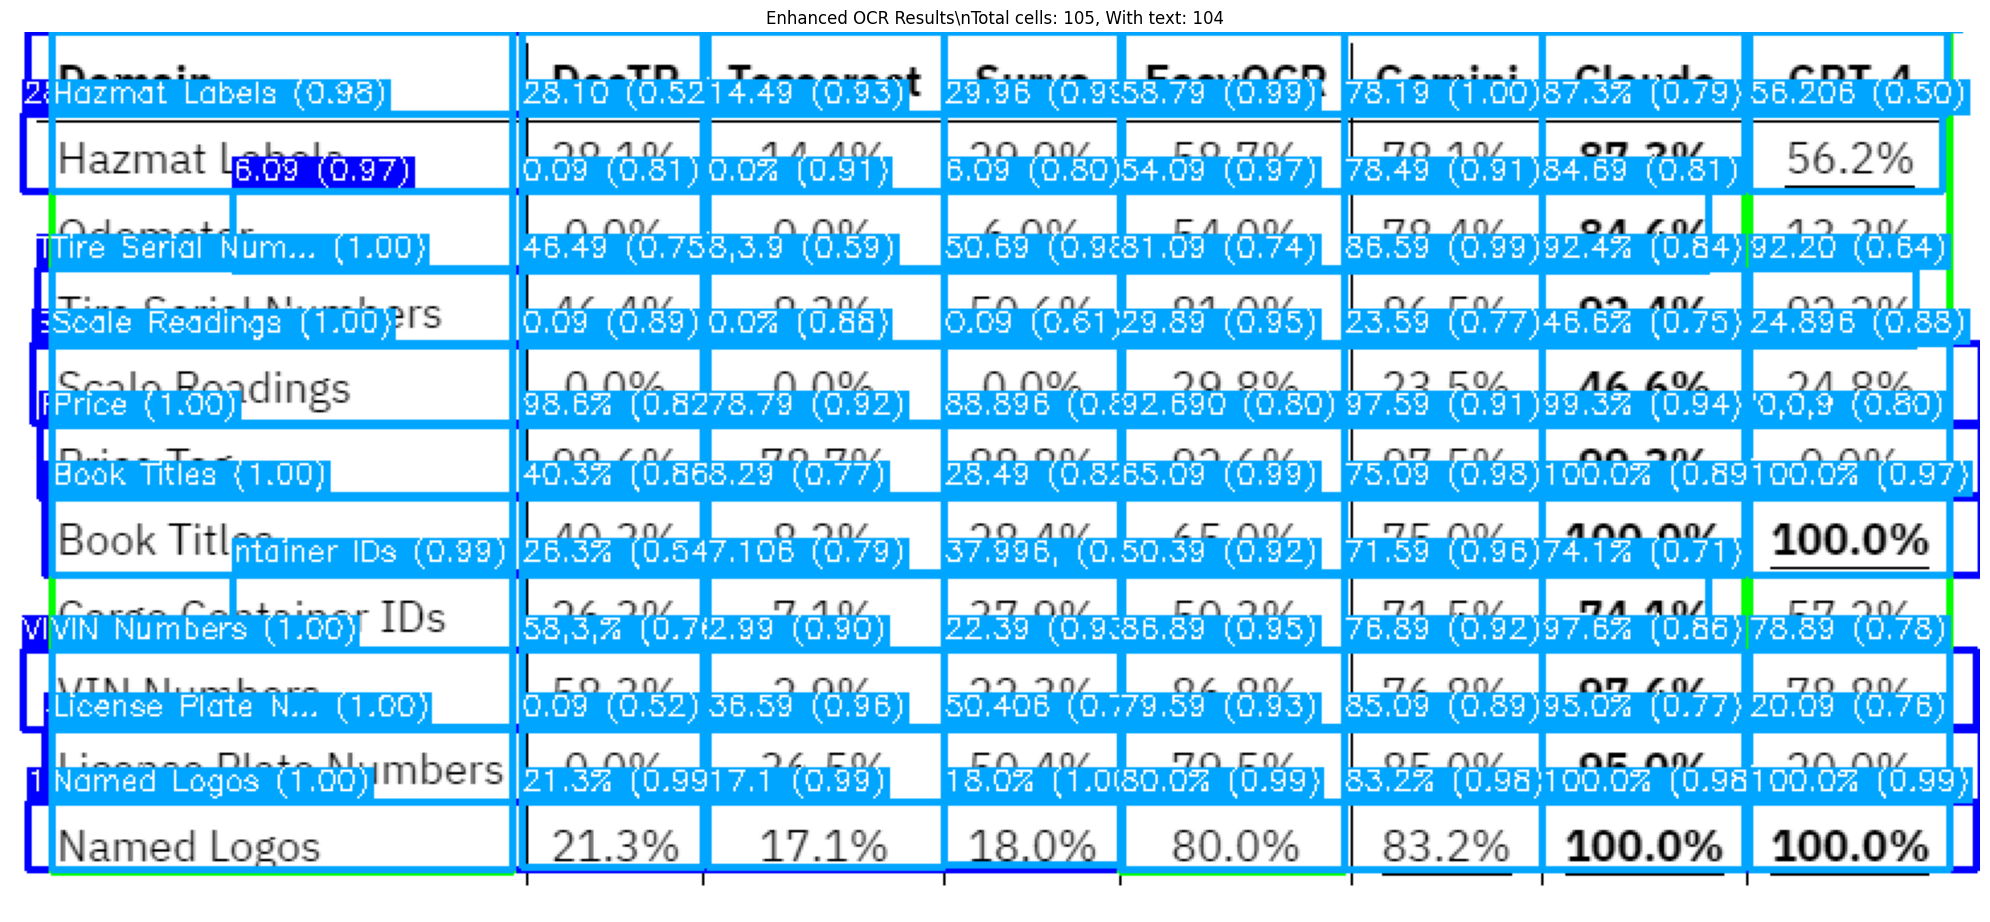

\n============================================================
🎉 ENHANCED OCR PROCESSING COMPLETE!
📊 Total cells processed: 105
📝 Cells with text: 104
🎯 Success rate: 99.0%
⬆️ Improvement: +85 additional text cells
📈 Confidence boost: +0.116
\n📁 Enhanced output files:
   - final_enhanced_results.json (complete enhanced data)
   - enhanced_structured_table.csv (structured table)
   - enhanced_ocr_results.json (detailed OCR results)
   - comparison_report.json (improvement metrics)
   - improvement_report.txt (human-readable report)
   - enhanced_detection_results.png (visualization with text)
   - enhanced_crop_*.png (individual enhanced cell crops)


In [17]:
# CELL 10: 🎉 FINAL RESULTS & COMPARISON
print("🎉 CELL 10: Final Results & Comparison")

def create_structured_table_from_enhanced_results(enhanced_results):
    """Create structured table from enhanced OCR results"""
    print("🏗️ Creating structured table from enhanced results...")
    
    # Separate grid cells from other detections
    grid_cells = [r for r in enhanced_results if r.get('row_index') is not None and r.get('col_index') is not None]
    other_results = [r for r in enhanced_results if r.get('row_index') is None]
    
    if grid_cells:
        print(f"📊 Found {len(grid_cells)} grid cells - creating structured table")
        
        # Get table dimensions
        max_row = max(cell['row_index'] for cell in grid_cells)
        max_col = max(cell['col_index'] for cell in grid_cells)
        
        # Create table matrix
        table_matrix = [['' for _ in range(max_col + 1)] for _ in range(max_row + 1)]
        cell_details = {}
        
        for cell in grid_cells:
            row_idx = cell['row_index']
            col_idx = cell['col_index']
            text = cell['text']
            
            table_matrix[row_idx][col_idx] = text
            cell_details[f"{row_idx}_{col_idx}"] = {
                'text': text,
                'confidence': cell['ocr_confidence'],
                'engine': cell['ocr_engine'],
                'bbox': cell['bbox']
            }
        
        # Save structured table as CSV
        df = pd.DataFrame(table_matrix)
        df.to_csv('enhanced_structured_table.csv', index=False, header=False, encoding='utf-8-sig')
        print("✅ Structured table saved to enhanced_structured_table.csv")
        
        # Count non-empty cells
        non_empty_cells = sum(1 for row in table_matrix for cell in row if cell.strip())
        print(f"📈 Table structure: {max_row+1} rows × {max_col+1} columns")
        print(f"📝 Non-empty cells: {non_empty_cells} / {(max_row+1)*(max_col+1)} ({non_empty_cells/((max_row+1)*(max_col+1))*100:.1f}%)")
        
        return table_matrix, cell_details
    
    else:
        print("⚠️ No grid cells found - saving unstructured results")
        return None, None

def create_comparison_report(basic_results, enhanced_results):
    """Create comparison report between basic and enhanced results"""
    print("📊 Creating comparison report...")
    
    # Count text-containing results
    basic_with_text = sum(1 for r in basic_results if r.get('text', '').strip()) if basic_results else 0
    enhanced_with_text = sum(1 for r in enhanced_results if r.get('text', '').strip())
    
    # Calculate average confidences
    basic_avg_conf = np.mean([r.get('ocr_confidence', 0) for r in basic_results if r.get('text', '').strip()]) if basic_results and basic_with_text > 0 else 0
    enhanced_avg_conf = np.mean([r.get('ocr_confidence', 0) for r in enhanced_results if r.get('text', '').strip()]) if enhanced_with_text > 0 else 0
    
    report = {
        'processing_date': pd.Timestamp.now().isoformat(),
        'basic_results': {
            'total_cells': len(basic_results) if basic_results else 0,
            'cells_with_text': basic_with_text,
            'success_rate': f"{basic_with_text/(len(basic_results) if basic_results else 1)*100:.1f}%",
            'avg_confidence': basic_avg_conf
        },
        'enhanced_results': {
            'total_cells': len(enhanced_results),
            'cells_with_text': enhanced_with_text,
            'success_rate': f"{enhanced_with_text/len(enhanced_results)*100:.1f}%",
            'avg_confidence': enhanced_avg_conf
        },
        'improvement': {
            'additional_text_cells': enhanced_with_text - basic_with_text,
            'confidence_improvement': enhanced_avg_conf - basic_avg_conf,
            'success_rate_improvement': f"{(enhanced_with_text/len(enhanced_results) - basic_with_text/(len(basic_results) if basic_results else 1))*100:.1f}%"
        }
    }
    
    # Save comparison report
    with open('comparison_report.json', 'w', encoding='utf-8') as f:
        json.dump(report, f, indent=2, ensure_ascii=False, default=str)
    
    # Create human-readable report
    with open('improvement_report.txt', 'w', encoding='utf-8') as f:
        f.write("=== OCR IMPROVEMENT REPORT ===\\n\\n")
        f.write(f"Processing Date: {report['processing_date']}\\n\\n")
        
        f.write("BASIC RESULTS:\\n")
        f.write(f"- Total cells: {report['basic_results']['total_cells']}\\n")
        f.write(f"- Cells with text: {report['basic_results']['cells_with_text']}\\n")
        f.write(f"- Success rate: {report['basic_results']['success_rate']}\\n")
        f.write(f"- Average confidence: {report['basic_results']['avg_confidence']:.3f}\\n\\n")
        
        f.write("ENHANCED RESULTS:\\n")
        f.write(f"- Total cells: {report['enhanced_results']['total_cells']}\\n")
        f.write(f"- Cells with text: {report['enhanced_results']['cells_with_text']}\\n")
        f.write(f"- Success rate: {report['enhanced_results']['success_rate']}\\n")
        f.write(f"- Average confidence: {report['enhanced_results']['avg_confidence']:.3f}\\n\\n")
        
        f.write("IMPROVEMENTS:\\n")
        f.write(f"- Additional text cells: +{report['improvement']['additional_text_cells']}\\n")
        f.write(f"- Confidence improvement: +{report['improvement']['confidence_improvement']:.3f}\\n")
        f.write(f"- Success rate improvement: {report['improvement']['success_rate_improvement']}\\n\\n")
        
        # Show best enhanced results
        if enhanced_results:
            best_enhanced = sorted([r for r in enhanced_results if r.get('text', '').strip()], 
                                 key=lambda x: x.get('ocr_confidence', 0), reverse=True)[:15]
            
            f.write("TOP 15 ENHANCED RESULTS:\\n")
            for i, result in enumerate(best_enhanced, 1):
                text = result.get('text', '')[:50].replace('\\n', ' ')
                conf = result.get('ocr_confidence', 0)
                engine = result.get('ocr_engine', 'Unknown')
                f.write(f"{i:2d}. '{text}' (conf: {conf:.3f}, {engine})\\n")
    
    print("✅ Comparison report saved to comparison_report.json and improvement_report.txt")
    return report

def visualize_enhanced_results(detections, image, enhanced_results, save_path="enhanced_detection_results.png"):
    """Visualize enhanced results with text overlay"""
    print("🎨 Creating enhanced visualization...")
    
    vis_image = image.copy()
    
    # Colors for different types
    colors = {
        'rows': (255, 0, 0),      # Red
        'columns': (0, 255, 0),   # Green
        'cells': (0, 0, 255),     # Blue
        'grid_cell': (255, 165, 0), # Orange
        'tables': (255, 255, 0),  # Yellow
    }
    
    # Draw bounding boxes and text
    for result in enhanced_results:
        bbox = result['bbox']
        text = result.get('text', '').strip()
        confidence = result.get('ocr_confidence', 0)
        detection_type = result.get('detection_type', 'unknown')
        
        x1, y1, x2, y2 = bbox
        color = colors.get(detection_type, (128, 128, 128))
        
        # Draw bounding box
        cv2.rectangle(vis_image, (x1, y1), (x2, y2), color, 2)
        
        # Draw text if available
        if text:
            display_text = text[:15] + ('...' if len(text) > 15 else '')
            label = f"{display_text} ({confidence:.2f})"
            
            font_scale = 0.4
            font_thickness = 1
            (text_width, text_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)
            
            # Draw text background
            cv2.rectangle(vis_image, 
                         (x1, y1 - text_height - 5), 
                         (x1 + text_width, y1), 
                         color, -1)
            
            # Draw text
            cv2.putText(vis_image, label, (x1, y1 - 5), 
                       cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), font_thickness)
    
    # Save enhanced visualization
    cv2.imwrite(save_path, vis_image)
    print(f"✅ Enhanced visualization saved to {save_path}")
    
    # Display with matplotlib
    plt.figure(figsize=(20, 15))
    plt.imshow(cv2.cvtColor(vis_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Enhanced OCR Results\\nTotal cells: {len(enhanced_results)}, " +
              f"With text: {sum(1 for r in enhanced_results if r.get('text', '').strip())}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return vis_image

# Process final enhanced results if available
if 'all_enhanced_results' in globals() and all_enhanced_results:
    print("🚀 Creating final enhanced results...")
    
    # Create structured table
    table_matrix, cell_details = create_structured_table_from_enhanced_results(all_enhanced_results)
    
    # Create comparison report (compare with basic if available)
    basic_ocr_results = globals().get('basic_ocr_results', [])
    comparison_report = create_comparison_report(basic_ocr_results, all_enhanced_results)
    
    # Create enhanced visualization
    detections, image, class_counts = detection_result
    enhanced_vis = visualize_enhanced_results(detections, image, all_enhanced_results)
    
    # Save final comprehensive results
    final_enhanced_data = {
        'metadata': {
            'processing_date': pd.Timestamp.now().isoformat(),
            'total_enhanced_results': len(all_enhanced_results),
            'cells_with_text': sum(1 for r in all_enhanced_results if r.get('text', '').strip()),
            'processing_methods': list(set(r.get('processing_method', 'unknown') for r in all_enhanced_results)),
            'ocr_engines_used': list(set(r.get('ocr_engine', 'unknown') for r in all_enhanced_results if r.get('text', '').strip()))
        },
        'enhanced_results': all_enhanced_results,
        'structured_table': table_matrix,
        'cell_details': cell_details,
        'comparison': comparison_report
    }
    
    with open('final_enhanced_results.json', 'w', encoding='utf-8') as f:
        json.dump(final_enhanced_data, f, indent=2, ensure_ascii=False, default=str)
    
    # Final summary
    print("\\n" + "="*60)
    print("🎉 ENHANCED OCR PROCESSING COMPLETE!")
    print("="*60)
    print(f"📊 Total cells processed: {len(all_enhanced_results)}")
    print(f"📝 Cells with text: {sum(1 for r in all_enhanced_results if r.get('text', '').strip())}")
    print(f"🎯 Success rate: {sum(1 for r in all_enhanced_results if r.get('text', '').strip())/len(all_enhanced_results)*100:.1f}%")
    
    if comparison_report['improvement']['additional_text_cells'] > 0:
        print(f"⬆️ Improvement: +{comparison_report['improvement']['additional_text_cells']} additional text cells")
        print(f"📈 Confidence boost: +{comparison_report['improvement']['confidence_improvement']:.3f}")
    
    print("\\n📁 Enhanced output files:")
    print("   - final_enhanced_results.json (complete enhanced data)")
    print("   - enhanced_structured_table.csv (structured table)")
    print("   - enhanced_ocr_results.json (detailed OCR results)")
    print("   - comparison_report.json (improvement metrics)")
    print("   - improvement_report.txt (human-readable report)")
    print("   - enhanced_detection_results.png (visualization with text)")
    print("   - enhanced_crop_*.png (individual enhanced cell crops)")
    print("="*60)

else:
    print("⚠️ No enhanced results found. Run CELL 9 first.")


In [18]:
# CELL 12: 💡 IMPROVED CELL DETECTION - Row ∩ Column Intersections
print("💡 CELL 12: Improved Cell Detection - Row ∩ Column Intersections")

def calculate_row_column_intersections(detections, original_image, show_debug=True):
    """
    Ý tưởng: Cell = Row ∩ Column (Giao điểm hàng và cột)
    Thay vì detect cells trực tiếp, tính toán giao điểm của rows và columns
    """
    print("🎯 Implementing idea: Cell = Row ∩ Column")
    
    rows = detections.get('rows', [])
    columns = detections.get('columns', [])
    
    if not rows or not columns:
        print("❌ Cần có cả rows và columns để tính giao điểm")
        return []
    
    print(f"📊 Input: {len(rows)} rows × {len(columns)} columns")
    print(f"🎯 Potential cells: {len(rows) * len(columns)} intersections")
    
    # Sort rows và columns theo vị trí
    rows_sorted = sorted(rows, key=lambda x: x['bbox'][1])  # Sort by Y position
    columns_sorted = sorted(columns, key=lambda x: x['bbox'][0])  # Sort by X position
    
    if show_debug:
        print("🔍 Debug info:")
        print(f"   📏 Rows Y positions: {[r['bbox'][1] for r in rows_sorted[:5]]}...")
        print(f"   📋 Columns X positions: {[c['bbox'][0] for c in columns_sorted[:5]]}...")
    
    # Enhanced preprocessing
    preprocessor = AdvancedImagePreprocessor()
    enhanced_image = preprocessor.multi_scale_enhancement(original_image)
    
    intersection_cells = []
    valid_intersections = 0
    
    # Calculate all intersections
    for row_idx, row in enumerate(rows_sorted):
        for col_idx, col in enumerate(columns_sorted):
            
            # Get bounding boxes
            row_bbox = row['bbox']  # [x1, y1, x2, y2]
            col_bbox = col['bbox']  # [x1, y1, x2, y2]
            
            # Calculate intersection
            # Intersection = overlap area between row and column
            x1_intersect = max(row_bbox[0], col_bbox[0])  # Left edge
            y1_intersect = max(row_bbox[1], col_bbox[1])  # Top edge  
            x2_intersect = min(row_bbox[2], col_bbox[2])  # Right edge
            y2_intersect = min(row_bbox[3], col_bbox[3])  # Bottom edge
            
            # Check if intersection is valid (has positive area)
            width = x2_intersect - x1_intersect
            height = y2_intersect - y1_intersect
            
            # Minimum cell size thresholds
            min_width = 15   # Minimum cell width
            min_height = 10  # Minimum cell height
            
            if width > min_width and height > min_height:
                # Valid intersection found!
                valid_intersections += 1
                
                # Add margin for better OCR
                margin = 3
                x1_margin = max(0, x1_intersect - margin)
                y1_margin = max(0, y1_intersect - margin)
                x2_margin = min(enhanced_image.shape[1], x2_intersect + margin)
                y2_margin = min(enhanced_image.shape[0], y2_intersect + margin)
                
                # Extract cell region
                cell_region = enhanced_image[y1_margin:y2_margin, x1_margin:x2_margin]
                
                if cell_region.size > 0:
                    # OCR the intersection cell
                    text, conf, engine = advanced_ocr.extract_text_comprehensive(
                        cell_region,
                        cell_info={
                            'type': 'intersection_cell',
                            'row': row_idx,
                            'col': col_idx,
                            'method': 'row_column_intersection'
                        }
                    )
                    
                    # Calculate confidence metrics
                    avg_detection_conf = (row['confidence'] + col['confidence']) / 2
                    
                    cell_result = {
                        'detection_type': 'intersection_cell',
                        'bbox': [x1_intersect, y1_intersect, x2_intersect, y2_intersect],
                        'margined_bbox': [x1_margin, y1_margin, x2_margin, y2_margin],
                        'row_index': row_idx,
                        'col_index': col_idx,
                        'row_bbox': row_bbox,
                        'column_bbox': col_bbox,
                        'intersection_area': width * height,
                        'cell_size': f"{width}x{height}",
                        'text': text.strip(),
                        'ocr_confidence': conf,
                        'ocr_engine': engine,
                        'detection_confidence': avg_detection_conf,
                        'enhanced': True,
                        'processing_method': 'row_column_intersection_v2'
                    }
                    
                    intersection_cells.append(cell_result)
                    
                    # Debug info for first few valid cells
                    if show_debug and valid_intersections <= 5:
                        print(f"   ✅ Cell[{row_idx},{col_idx}]: {width}x{height}, text='{text[:20]}...' ({conf:.3f})")
    
    print(f"🎯 Results:")
    print(f"   📊 Total potential intersections: {len(rows) * len(columns)}")
    print(f"   ✅ Valid intersections: {valid_intersections}")
    print(f"   📝 Cells with text: {sum(1 for c in intersection_cells if c['text'].strip())}")
    
    return intersection_cells

def create_structured_matrix_from_intersections(intersection_cells):
    """Tạo ma trận có cấu trúc từ intersection cells"""
    print("🏗️ Creating structured matrix from intersections...")
    
    if not intersection_cells:
        print("❌ No intersection cells to organize")
        return None
    
    # Get matrix dimensions
    max_row = max(cell['row_index'] for cell in intersection_cells)
    max_col = max(cell['col_index'] for cell in intersection_cells)
    
    print(f"📏 Matrix dimensions: {max_row+1} rows × {max_col+1} columns")
    
    # Create matrix
    matrix = []
    for r in range(max_row + 1):
        row = []
        for c in range(max_col + 1):
            # Find cell at position [r,c]
            cell_text = ""
            cell_conf = 0.0
            
            for cell in intersection_cells:
                if cell['row_index'] == r and cell['col_index'] == c:
                    cell_text = cell['text']
                    cell_conf = cell['ocr_confidence']
                    break
            
            row.append({
                'text': cell_text,
                'confidence': cell_conf,
                'position': f"[{r},{c}]"
            })
        matrix.append(row)
    
    # Save matrix as CSV
    csv_data = []
    for row in matrix:
        csv_row = [cell['text'] for cell in row]
        csv_data.append(csv_row)
    
    df = pd.DataFrame(csv_data)
    df.to_csv('intersection_structured_table.csv', index=False, header=False, encoding='utf-8-sig')
    print("✅ Structured matrix saved to intersection_structured_table.csv")
    
    # Statistics
    total_cells = (max_row + 1) * (max_col + 1)
    filled_cells = sum(1 for row in matrix for cell in row if cell['text'].strip())
    
    print(f"📊 Matrix Statistics:")
    print(f"   📏 Size: {max_row+1} × {max_col+1} = {total_cells} cells")
    print(f"   📝 Filled cells: {filled_cells} ({filled_cells/total_cells*100:.1f}%)")
    print(f"   🎯 Fill rate: {filled_cells/total_cells*100:.1f}%")
    
    return matrix

# Test improved intersection method if detection results are available
if 'detection_result' in globals() and detection_result[0] is not None:
    print("🚀 Testing improved Row ∩ Column intersection method...")
    detections, image, class_counts = detection_result
    
    # Method: Row ∩ Column intersections
    intersection_cells = calculate_row_column_intersections(detections, image, show_debug=True)
    
    if intersection_cells:
        # Create structured matrix
        structured_matrix = create_structured_matrix_from_intersections(intersection_cells)
        
        # Save detailed results
        with open('intersection_cells_results.json', 'w', encoding='utf-8') as f:
            json.dump(intersection_cells, f, indent=2, ensure_ascii=False)
        print("💾 Intersection results saved to intersection_cells_results.json")
        
        # Compare với method trước đó
        if 'all_enhanced_results' in globals():
            grid_cells_old = [r for r in all_enhanced_results if r.get('detection_type') == 'grid_cell']
            print(f"\\n📊 COMPARISON:")
            print(f"   📊 Old grid method: {len(grid_cells_old)} cells")
            print(f"   🆕 New intersection method: {len(intersection_cells)} cells")
            print(f"   📝 Text extracted: Old={sum(1 for c in grid_cells_old if c.get('text', '').strip())}, New={sum(1 for c in intersection_cells if c['text'].strip())}")
        
        print("🎯 Improved Row ∩ Column intersection method complete!")
    else:
        print("❌ No valid intersections found")

else:
    print("⚠️ No detection results found. Run CELL 3 first.")


💡 CELL 12: Improved Cell Detection - Row ∩ Column Intersections
🚀 Testing improved Row ∩ Column intersection method...
🎯 Implementing idea: Cell = Row ∩ Column
📊 Input: 11 rows × 8 columns
🎯 Potential cells: 88 intersections
🔍 Debug info:
   📏 Rows Y positions: [0, 34, 66, 98, 129]...
   📋 Columns X positions: [17, 212, 289, 387, 460]...
      🔍 Processing cell 197x37
   🔍 Upscaled by 2x: (74, 394)
   ✅ Cell[0,0]: 191x34, text='Domain...' (0.975)
      🔍 Processing cell 81x37
   🔍 Upscaled by 2x: (74, 162)
   ✅ Cell[0,1]: 75x34, text='DocTR...' (1.000)
      🔍 Processing cell 104x37
   🔍 Upscaled by 2x: (74, 208)
   ✅ Cell[0,2]: 98x34, text='Tesseract...' (0.997)
      🔍 Processing cell 80x37
   🔍 Upscaled by 2x: (74, 160)
   ✅ Cell[0,3]: 74x34, text='Surya...' (1.000)
      🔍 Processing cell 99x37
   🔍 Upscaled by 2x: (74, 198)
   ✅ Cell[0,4]: 93x34, text='EasyOCR...' (0.986)
      🔍 Processing cell 88x37
   🔍 Upscaled by 2x: (74, 176)
      🔍 Processing cell 90x37
   🔍 Upscaled by 2x

In [22]:
# CELL 13: 🏆 OCR ENGINES COMPARISON - EasyOCR vs Tesseract vs PaddleOCR vs TrOCR vs docTR
print("🏆 CELL 13: Comprehensive OCR Engines Comparison")

import time
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings from OCR libraries
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Check for pytesseract-specific import
try:
    import pytesseract
    # Try to import TesseractNotFoundError
    try:
        from pytesseract import TesseractNotFoundError
    except ImportError:
        # Create a dummy exception for older versions
        class TesseractNotFoundError(Exception):
            pass
        pytesseract.TesseractNotFoundError = TesseractNotFoundError
except ImportError:
    pass

class ComprehensiveOCRBenchmark:
    """Comprehensive OCR benchmark với 5 engines: EasyOCR, Tesseract, PaddleOCR, TrOCR, docTR"""
    
    def __init__(self):
        print("🔧 Initializing ALL OCR engines for comparison...")
        self.engines = {}
        self.engine_status = {}
        
        # 1. EasyOCR
        self._init_easyocr()
        
        # 2. Pytesseract
        self._init_tesseract()
        
        # 3. PaddleOCR
        self._init_paddleocr()
        
        # 4. TrOCR (Microsoft Transformer OCR)
        self._init_trocr()
        
        # 5. docTR (Document Text Recognition)
        self._init_doctr()
        
        # Summary
        available = [name for name, status in self.engine_status.items() if status]
        print(f"🎯 Available engines: {len(available)}/5")
        print(f"✅ Ready: {', '.join(available)}")
        unavailable = [name for name, status in self.engine_status.items() if not status]
        if unavailable:
            print(f"❌ Unavailable: {', '.join(unavailable)}")
    
    def _init_easyocr(self):
        """Initialize EasyOCR"""
        try:
            import easyocr
            self.engines['EasyOCR'] = easyocr.Reader(['en'], gpu=False)
            self.engine_status['EasyOCR'] = True
            print("✅ EasyOCR ready")
        except Exception as e:
            print(f"❌ EasyOCR failed: {e}")
            self.engine_status['EasyOCR'] = False
    
    def _init_tesseract(self):
        """Initialize Tesseract"""
        try:
            import pytesseract
            # Check if tesseract executable is available
            try:
                version = pytesseract.get_tesseract_version()
                self.engines['Tesseract'] = pytesseract
                self.engine_status['Tesseract'] = True
                print(f"✅ Tesseract ready (version: {version})")
            except pytesseract.TesseractNotFoundError:
                print("❌ Tesseract failed: Tesseract executable not found!")
                print("💡 Install instructions:")
                print("   Windows: Download from https://github.com/UB-Mannheim/tesseract/wiki")
                print("   Ubuntu: sudo apt install tesseract-ocr")
                print("   macOS: brew install tesseract")
                self.engine_status['Tesseract'] = False
        except ImportError:
            print("❌ Tesseract failed: pytesseract module not installed. Run: pip install pytesseract")
            self.engine_status['Tesseract'] = False
        except Exception as e:
            print(f"❌ Tesseract failed: {e}")
            self.engine_status['Tesseract'] = False
    
    def _init_paddleocr(self):
        """Initialize PaddleOCR"""
        try:
            from paddleocr import PaddleOCR
            # Try different initialization methods for different PaddleOCR versions
            try:
                # Newer version
                self.engines['PaddleOCR'] = PaddleOCR(use_angle_cls=True, lang='en', show_log=False)
            except:
                try:
                    # Older version without show_log parameter
                    self.engines['PaddleOCR'] = PaddleOCR(use_angle_cls=True, lang='en')
                except:
                    # Minimal initialization
                    self.engines['PaddleOCR'] = PaddleOCR(lang='en')
            
            self.engine_status['PaddleOCR'] = True
            print("✅ PaddleOCR ready")
        except ImportError:
            print("❌ PaddleOCR failed: Module not installed. Run: pip install paddleocr")
            self.engine_status['PaddleOCR'] = False
        except Exception as e:
            print(f"❌ PaddleOCR failed: {e}")
            print("💡 Try: pip install --upgrade paddleocr")
            self.engine_status['PaddleOCR'] = False
    
    def _init_trocr(self):
        """Initialize TrOCR (Microsoft Transformer OCR)"""
        try:
            from transformers import TrOCRProcessor, VisionEncoderDecoderModel
            from PIL import Image as PILImage
            
            print("🔄 Loading TrOCR models (this may take a while)...")
            processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")
            model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-printed")
            
            self.engines['TrOCR'] = {
                'processor': processor,
                'model': model
            }
            self.engine_status['TrOCR'] = True
            print("✅ TrOCR ready")
        except ImportError as e:
            print(f"❌ TrOCR failed: Missing dependencies - {e}")
            print("💡 Install with: pip install transformers torch")
            self.engine_status['TrOCR'] = False
        except Exception as e:
            print(f"❌ TrOCR failed: {e}")
            print("💡 This might be due to network issues or model download problems")
            self.engine_status['TrOCR'] = False
    
    def _init_doctr(self):
        """Initialize docTR"""
        try:
            from doctr.io import DocumentFile
            from doctr.models import ocr_predictor
            
            print("🔄 Loading docTR model...")
            model = ocr_predictor(pretrained=True)
            self.engines['docTR'] = model
            self.engine_status['docTR'] = True
            print("✅ docTR ready")
        except ImportError as e:
            print(f"❌ docTR failed: Module not installed - {e}")
            print("💡 Install with: pip install python-doctr[torch]")
            print("   or: pip install python-doctr[tf] for TensorFlow")
            self.engine_status['docTR'] = False
        except Exception as e:
            print(f"❌ docTR failed: {e}")
            print("💡 This might be due to model download issues or missing dependencies")
            self.engine_status['docTR'] = False
    
    def ocr_with_easyocr(self, image):
        """OCR with EasyOCR"""
        if not self.engine_status['EasyOCR']:
            return "", 0.0, 0.0
        
        try:
            start_time = time.time()
            if len(image.shape) == 3:
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            else:
                image_rgb = image
            
            results = self.engines['EasyOCR'].readtext(image_rgb)
            process_time = time.time() - start_time
            
            if results:
                texts = []
                confidences = []
                for (bbox, text, confidence) in results:
                    if confidence > 0.1:
                        texts.append(text)
                        confidences.append(confidence)
                
                if texts:
                    return ' '.join(texts), np.mean(confidences), process_time
            
            return "", 0.0, process_time
        except Exception as e:
            return f"ERROR: {e}", 0.0, 0.0
    
    def ocr_with_tesseract(self, image):
        """OCR with Tesseract"""
        if not self.engine_status['Tesseract']:
            return "", 0.0, 0.0
        
        try:
            start_time = time.time()
            config = '--oem 3 --psm 6'
            
            # Get text and confidence
            data = self.engines['Tesseract'].image_to_data(
                image, config=config, 
                output_type=self.engines['Tesseract'].Output.DICT
            )
            
            texts = []
            confidences = []
            for i in range(len(data['text'])):
                if int(data['conf'][i]) > 10:
                    text = data['text'][i].strip()
                    if text:
                        texts.append(text)
                        confidences.append(int(data['conf'][i]))
            
            process_time = time.time() - start_time
            
            if texts:
                return ' '.join(texts), np.mean(confidences) / 100.0, process_time
            return "", 0.0, process_time
            
        except Exception as e:
            return f"ERROR: {e}", 0.0, 0.0
    
    def ocr_with_paddleocr(self, image):
        """OCR with PaddleOCR"""
        if not self.engine_status['PaddleOCR']:
            return "", 0.0, 0.0
        
        try:
            start_time = time.time()
            from PIL import Image as PILImage
            
            # Convert image to numpy array for PaddleOCR
            if isinstance(image, np.ndarray):
                # PaddleOCR works better with RGB images
                if len(image.shape) == 2:  # Grayscale
                    # Convert grayscale to RGB
                    ocr_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
                elif len(image.shape) == 3:  # Color
                    if image.shape[2] == 3:  # BGR
                        ocr_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    else:  # Already RGB
                        ocr_image = image
                else:
                    ocr_image = image
            else:
                # Convert PIL to numpy array
                ocr_image = np.array(image)
            
            # Run PaddleOCR
            results = self.engines['PaddleOCR'].ocr(ocr_image)
            process_time = time.time() - start_time
            
            # Parse results (handle different PaddleOCR versions)
            if results and len(results) > 0:
                # Handle nested structure
                result_lines = results[0] if isinstance(results[0], list) else results
                
                if result_lines:
                    texts = []
                    confidences = []
                    
                    for line in result_lines:
                        if line and len(line) >= 2:
                            # Handle different result formats
                            if isinstance(line[1], (list, tuple)) and len(line[1]) >= 2:
                                text = str(line[1][0])
                                conf = float(line[1][1])
                            elif isinstance(line[1], str):
                                text = line[1]
                                conf = 0.8  # Default confidence if not provided
                            else:
                                continue
                            
                            if conf > 0.1 and text.strip():
                                texts.append(text.strip())
                                confidences.append(conf)
                    
                    if texts:
                        return ' '.join(texts), np.mean(confidences), process_time
            
            return "", 0.0, process_time
            
        except Exception as e:
            return f"ERROR: {str(e)}", 0.0, 0.0
    
    def ocr_with_trocr(self, image):
        """OCR with TrOCR"""
        if not self.engine_status['TrOCR']:
            return "", 0.0, 0.0
        
        try:
            start_time = time.time()
            from PIL import Image as PILImage
            import torch
            
            # Convert to PIL
            if isinstance(image, np.ndarray):
                if len(image.shape) == 2:
                    pil_image = PILImage.fromarray(image, mode='L').convert('RGB')
                else:
                    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    pil_image = PILImage.fromarray(image_rgb)
            
            # Process with TrOCR
            processor = self.engines['TrOCR']['processor']
            model = self.engines['TrOCR']['model']
            
            pixel_values = processor(images=pil_image, return_tensors="pt").pixel_values
            generated_ids = model.generate(pixel_values)
            generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
            
            process_time = time.time() - start_time
            
            # TrOCR doesn't provide confidence, so we estimate based on text length
            confidence = min(len(generated_text.strip()) / 20.0, 1.0) if generated_text.strip() else 0.0
            
            return generated_text.strip(), confidence, process_time
            
        except Exception as e:
            return f"ERROR: {e}", 0.0, 0.0
    
    def ocr_with_doctr(self, image):
        """OCR with docTR"""
        if not self.engine_status['docTR']:
            return "", 0.0, 0.0
        
        try:
            start_time = time.time()
            from PIL import Image as PILImage
            
            # Convert to PIL
            if isinstance(image, np.ndarray):
                if len(image.shape) == 2:
                    pil_image = PILImage.fromarray(image, mode='L').convert('RGB')
                else:
                    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    pil_image = PILImage.fromarray(image_rgb)
            
            # Process with docTR
            doc = self.engines['docTR']([pil_image])
            process_time = time.time() - start_time
            
            # Extract text from docTR result
            text_parts = []
            total_confidence = 0.0
            count = 0
            
            for page in doc.pages:
                for block in page.blocks:
                    for line in block.lines:
                        for word in line.words:
                            text_parts.append(word.value)
                            total_confidence += word.confidence
                            count += 1
            
            combined_text = ' '.join(text_parts)
            avg_confidence = total_confidence / count if count > 0 else 0.0
            
            return combined_text, avg_confidence, process_time
            
        except Exception as e:
            return f"ERROR: {e}", 0.0, 0.0
    
    def benchmark_all_engines(self, test_images, image_names=None):
        """Benchmark all available engines on test images"""
        print(f"🏁 Starting comprehensive OCR benchmark on {len(test_images)} images...")
        
        if image_names is None:
            image_names = [f"Image_{i+1}" for i in range(len(test_images))]
        
        results = {
            'images': image_names,
            'engines': {},
            'summary': {}
        }
        
        # OCR methods mapping
        ocr_methods = {
            'EasyOCR': self.ocr_with_easyocr,
            'Tesseract': self.ocr_with_tesseract,
            'PaddleOCR': self.ocr_with_paddleocr,
            'TrOCR': self.ocr_with_trocr,
            'docTR': self.ocr_with_doctr
        }
        
        # Run OCR with each engine
        for engine_name, ocr_method in ocr_methods.items():
            if not self.engine_status[engine_name]:
                continue
                
            print(f"🔄 Testing {engine_name}...")
            engine_results = {
                'texts': [],
                'confidences': [],
                'processing_times': [],
                'success_rate': 0.0,
                'avg_confidence': 0.0,
                'avg_time': 0.0,
                'total_characters': 0
            }
            
            successful_ocr = 0
            
            for i, image in enumerate(test_images):
                text, confidence, proc_time = ocr_method(image)
                
                engine_results['texts'].append(text)
                engine_results['confidences'].append(confidence)
                engine_results['processing_times'].append(proc_time)
                
                if text.strip() and not text.startswith('ERROR'):
                    successful_ocr += 1
                    engine_results['total_characters'] += len(text.strip())
                
                # Progress for slower engines
                if engine_name in ['TrOCR', 'docTR'] and (i + 1) % 5 == 0:
                    print(f"   {engine_name}: {i+1}/{len(test_images)} completed...")
            
            # Calculate statistics
            engine_results['success_rate'] = successful_ocr / len(test_images)
            valid_confidences = [c for c in engine_results['confidences'] if c > 0]
            engine_results['avg_confidence'] = np.mean(valid_confidences) if valid_confidences else 0.0
            engine_results['avg_time'] = np.mean(engine_results['processing_times'])
            
            results['engines'][engine_name] = engine_results
            
            print(f"✅ {engine_name}: {successful_ocr}/{len(test_images)} successful ({engine_results['success_rate']*100:.1f}%)")
        
        # Create summary comparison
        self._create_benchmark_summary(results)
        
        return results
    
    def _create_benchmark_summary(self, results):
        """Create comprehensive benchmark summary"""
        print("\\n📊 COMPREHENSIVE OCR BENCHMARK RESULTS:")
        print("=" * 80)
        
        # Summary table
        summary_data = []
        for engine_name, engine_data in results['engines'].items():
            summary_data.append({
                'Engine': engine_name,
                'Success Rate': f"{engine_data['success_rate']*100:.1f}%",
                'Avg Confidence': f"{engine_data['avg_confidence']:.3f}",
                'Avg Time (s)': f"{engine_data['avg_time']:.3f}",
                'Total Characters': engine_data['total_characters'],
                'Characters/sec': f"{engine_data['total_characters']/engine_data['avg_time']:.1f}" if engine_data['avg_time'] > 0 else "N/A"
            })
        
        # Display summary table
        if summary_data:
            df_summary = pd.DataFrame(summary_data)
            print(df_summary.to_string(index=False))
            
            # Save summary
            df_summary.to_csv('ocr_engines_comparison.csv', index=False)
            print("\\n💾 Summary saved to ocr_engines_comparison.csv")
        
        # Find best performers
        print("\\n🏆 BEST PERFORMERS:")
        
        if results['engines']:
            # Best success rate
            best_success = max(results['engines'].items(), key=lambda x: x[1]['success_rate'])
            print(f"   🎯 Best Success Rate: {best_success[0]} ({best_success[1]['success_rate']*100:.1f}%)")
            
            # Best confidence
            best_confidence = max(results['engines'].items(), key=lambda x: x[1]['avg_confidence'])
            print(f"   🔍 Best Confidence: {best_confidence[0]} ({best_confidence[1]['avg_confidence']:.3f})")
            
            # Fastest
            fastest = min(results['engines'].items(), key=lambda x: x[1]['avg_time'])
            print(f"   ⚡ Fastest: {fastest[0]} ({fastest[1]['avg_time']:.3f}s avg)")
            
            # Most text extracted
            most_text = max(results['engines'].items(), key=lambda x: x[1]['total_characters'])
            print(f"   📝 Most Text: {most_text[0]} ({most_text[1]['total_characters']} chars)")

def install_missing_engines():
    """Helper function to install missing OCR engines"""
    print("🔧 OCR ENGINES INSTALLATION GUIDE:")
    print("=" * 50)
    
    print("\n📦 Python Packages:")
    print("pip install pytesseract paddleocr transformers torch python-doctr[torch]")
    
    print("\n🔧 System Dependencies:")
    print("Windows:")
    print("  - Download Tesseract: https://github.com/UB-Mannheim/tesseract/wiki")
    print("  - Add to PATH or set pytesseract.pytesseract.tesseract_cmd")
    
    print("\nUbuntu/Debian:")
    print("  sudo apt update")
    print("  sudo apt install tesseract-ocr tesseract-ocr-eng")
    
    print("\nmacOS:")
    print("  brew install tesseract")
    
    print("\n💡 Quick install command:")
    print("pip install easyocr pytesseract paddleocr transformers torch python-doctr[torch] --upgrade")

def test_single_engine(engine_name, test_image=None):
    """Test a single OCR engine with debug info"""
    if not hasattr(ocr_benchmark, 'engine_status'):
        print("❌ OCR benchmark not initialized. Run CELL 13 first.")
        return
    
    if engine_name not in ocr_benchmark.engine_status:
        print(f"❌ Unknown engine: {engine_name}")
        print(f"Available engines: {list(ocr_benchmark.engine_status.keys())}")
        return
    
    if not ocr_benchmark.engine_status[engine_name]:
        print(f"❌ Engine {engine_name} is not available")
        return
    
    # Create a test image if none provided
    if test_image is None:
        print("🔄 Creating test image...")
        test_image = np.ones((100, 300, 3), dtype=np.uint8) * 255
        cv2.putText(test_image, "Test OCR 123", (10, 50), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
    
    print(f"🧪 Testing {engine_name}...")
    
    # Get the OCR method
    ocr_methods = {
        'EasyOCR': ocr_benchmark.ocr_with_easyocr,
        'Tesseract': ocr_benchmark.ocr_with_tesseract,
        'PaddleOCR': ocr_benchmark.ocr_with_paddleocr,
        'TrOCR': ocr_benchmark.ocr_with_trocr,
        'docTR': ocr_benchmark.ocr_with_doctr
    }
    
    if engine_name in ocr_methods:
        try:
            text, confidence, process_time = ocr_methods[engine_name](test_image)
            print(f"✅ {engine_name} Result:")
            print(f"   📝 Text: '{text}'")
            print(f"   🎯 Confidence: {confidence:.3f}")
            print(f"   ⏱️ Time: {process_time:.3f}s")
        except Exception as e:
            print(f"❌ {engine_name} Error: {e}")
    else:
        print(f"❌ No test method for {engine_name}")

# Initialize comprehensive OCR benchmark
print("🚀 Initializing Comprehensive OCR Benchmark...")
ocr_benchmark = ComprehensiveOCRBenchmark()

# Show installation guide if engines are missing
available_count = sum(ocr_benchmark.engine_status.values())
if available_count < 3:
    print(f"\n⚠️ Only {available_count}/5 OCR engines available")
    print("🔗 Run install_missing_engines() for installation guide")
    print("🧪 Run test_single_engine('EasyOCR') to test individual engines")
    
    # Auto-show install guide
    install_missing_engines()
else:
    print(f"\n🎉 Successfully initialized {available_count}/5 OCR engines!")
    print("🧪 Test individual engines: test_single_engine('EasyOCR')")
    print("🚀 Ready for benchmark in CELL 14!")


Using CPU. Note: This module is much faster with a GPU.


🏆 CELL 13: Comprehensive OCR Engines Comparison
🚀 Initializing Comprehensive OCR Benchmark...
🔧 Initializing ALL OCR engines for comparison...
✅ EasyOCR ready
❌ Tesseract failed: Tesseract executable not found!
💡 Install instructions:
   Windows: Download from https://github.com/UB-Mannheim/tesseract/wiki
   Ubuntu: sudo apt install tesseract-ocr
   macOS: brew install tesseract


C:\Users\CNTT\AppData\Local\Temp\ipykernel_18188\2655417370.py:101: DeprecationWarning: The parameter `use_angle_cls` has been deprecated and will be removed in the future. Please use `use_textline_orientation` instead.
  self.engines['PaddleOCR'] = PaddleOCR(use_angle_cls=True, lang='en', show_log=False)
C:\Users\CNTT\AppData\Local\Temp\ipykernel_18188\2655417370.py:105: DeprecationWarning: The parameter `use_angle_cls` has been deprecated and will be removed in the future. Please use `use_textline_orientation` instead.
  self.engines['PaddleOCR'] = PaddleOCR(use_angle_cls=True, lang='en')
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Using official model (PP-LCNet_x1_0_doc_ori), the model files will be automatically downloaded and saved in C:\Users\CNTT\.paddlex\official_models.
Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 2993.08it/s]
Creating model: ('UVDoc', None)
The model(UVDoc) is not supported to run in MKLDNN mode! Using `paddle` instead!
Using official model (UVDoc

✅ PaddleOCR ready
❌ TrOCR failed: Missing dependencies - No module named 'transformers'
💡 Install with: pip install transformers torch
❌ docTR failed: Module not installed - No module named 'doctr'
💡 Install with: pip install python-doctr[torch]
   or: pip install python-doctr[tf] for TensorFlow
🎯 Available engines: 2/5
✅ Ready: EasyOCR, PaddleOCR
❌ Unavailable: Tesseract, TrOCR, docTR

⚠️ Only 2/5 OCR engines available
🔗 Run install_missing_engines() for installation guide
🧪 Run test_single_engine('EasyOCR') to test individual engines
🔧 OCR ENGINES INSTALLATION GUIDE:

📦 Python Packages:
pip install pytesseract paddleocr transformers torch python-doctr[torch]

🔧 System Dependencies:
Windows:
  - Download Tesseract: https://github.com/UB-Mannheim/tesseract/wiki
  - Add to PATH or set pytesseract.pytesseract.tesseract_cmd

Ubuntu/Debian:
  sudo apt update
  sudo apt install tesseract-ocr tesseract-ocr-eng

macOS:
  brew install tesseract

💡 Quick install command:
pip install easyocr pyt

🔬 CELL 14: Running OCR Engines Benchmark
🏁 Starting comprehensive OCR engines benchmark...
📥 Collecting test images from intersection cells...
📊 Selected 20 intersection cells for benchmark
✅ Collected 20 test images
🎯 Running benchmark on 20 test images...
🏁 Starting comprehensive OCR benchmark on 20 images...
🔄 Testing EasyOCR...
✅ EasyOCR: 19/20 successful (95.0%)
🔄 Testing PaddleOCR...


C:\Users\CNTT\AppData\Local\Temp\ipykernel_18188\2655417370.py:256: DeprecationWarning: Please use `predict` instead.
  results = self.engines['PaddleOCR'].ocr(ocr_image)


✅ PaddleOCR: 0/20 successful (0.0%)
\n📊 COMPREHENSIVE OCR BENCHMARK RESULTS:
   Engine Success Rate Avg Confidence Avg Time (s)  Total Characters Characters/sec
  EasyOCR        95.0%          0.790        0.051               109         2153.6
PaddleOCR         0.0%          0.000        0.000                 0            N/A
\n💾 Summary saved to ocr_engines_comparison.csv
\n🏆 BEST PERFORMERS:
   🎯 Best Success Rate: EasyOCR (95.0%)
   🔍 Best Confidence: EasyOCR (0.790)
   ⚡ Fastest: PaddleOCR (0.000s avg)
   📝 Most Text: EasyOCR (109 chars)
📊 Creating benchmark visualizations...


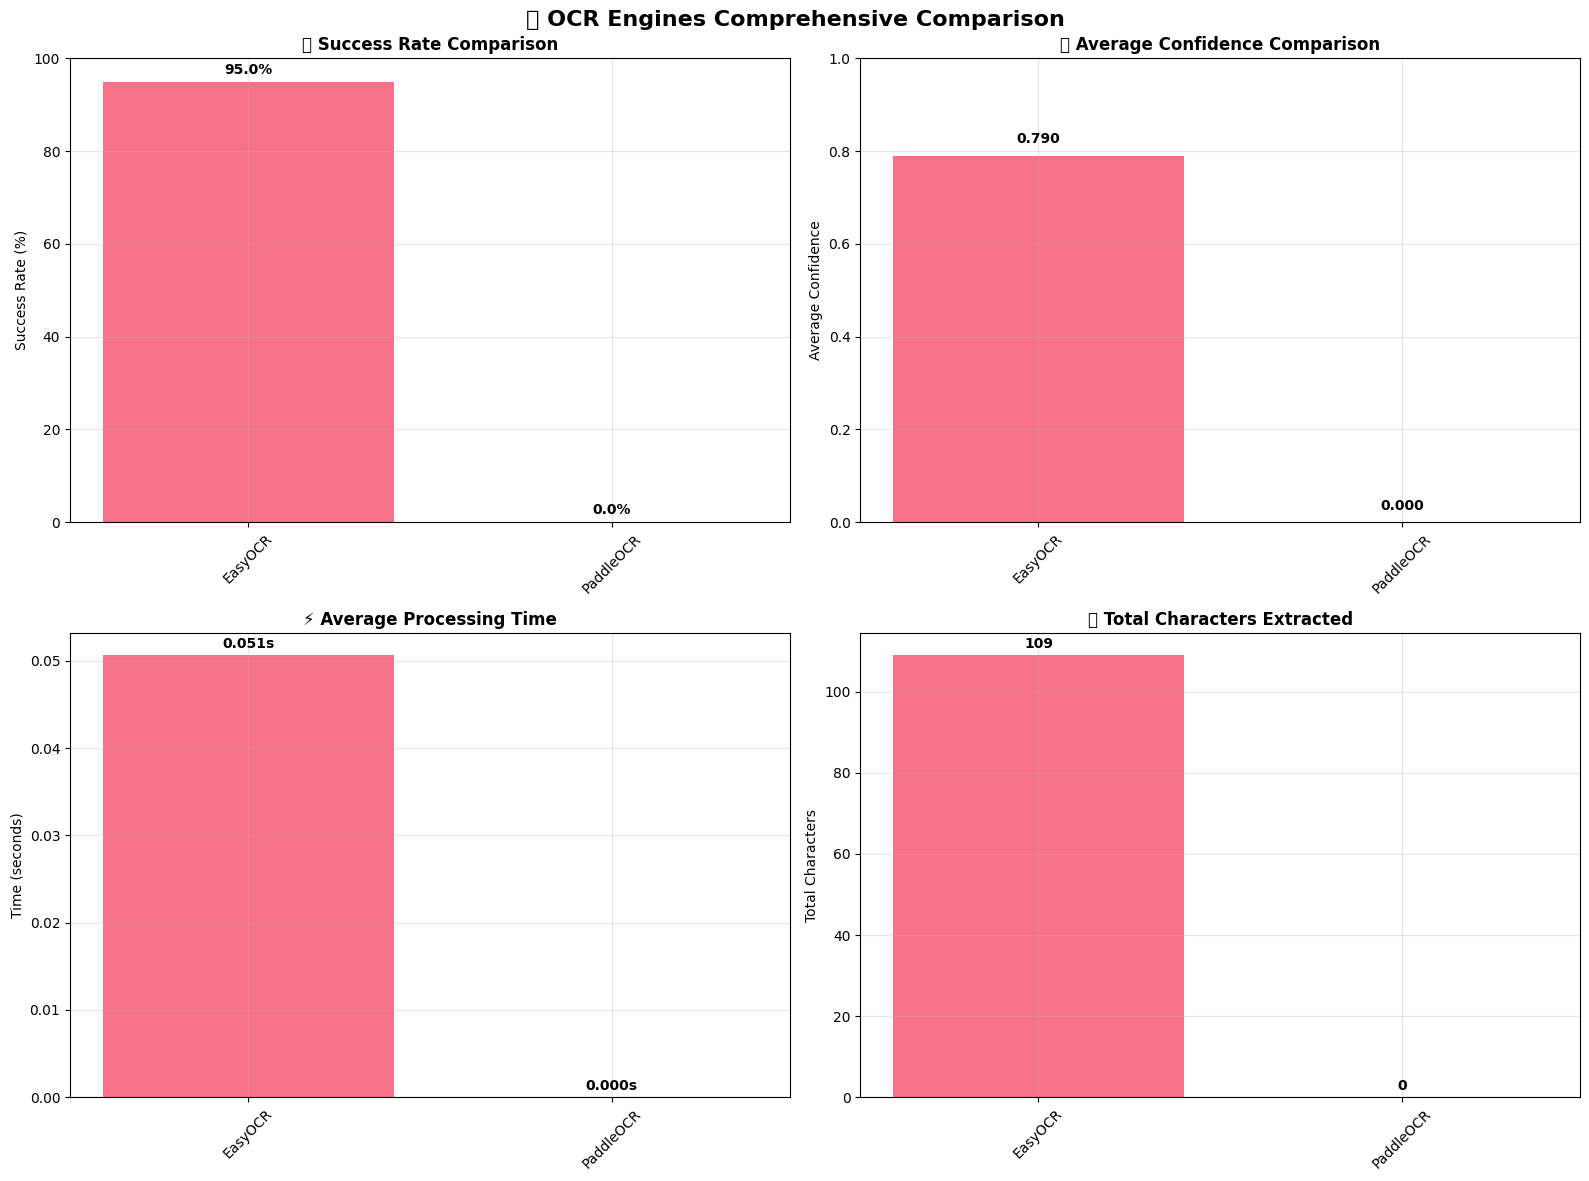

✅ Benchmark visualizations saved to ocr_engines_comparison_charts.png
📋 Creating detailed results analysis...
✅ Detailed analysis saved to ocr_engines_detailed_analysis.json
\n🔍 KEY INSIGHTS:
   🏆 Best Overall Performance: EasyOCR
   ⚡ Fastest Processing: PaddleOCR
   🎯 Most Reliable: EasyOCR
   🎯 EasyOCR recommended for general-purpose OCR
\n🎉 COMPREHENSIVE OCR BENCHMARK COMPLETE!
📁 Output files:
   - ocr_engines_comparison.csv (summary table)
   - ocr_engines_comparison_charts.png (visualizations)
   - ocr_engines_detailed_analysis.json (detailed analysis)
   - comprehensive_ocr_benchmark_results.json (raw results)


In [23]:
# CELL 14: 🔬 RUN OCR ENGINES BENCHMARK
print("🔬 CELL 14: Running OCR Engines Benchmark")

def collect_test_images_from_intersections():
    """Collect test images từ intersection cells đã tạo"""
    print("📥 Collecting test images from intersection cells...")
    
    if 'intersection_cells' not in globals() or not intersection_cells:
        print("❌ No intersection cells found. Run CELL 12 first to generate test images.")
        return [], []
    
    test_images = []
    image_names = []
    
    if 'detection_result' in globals() and detection_result[0] is not None:
        detections, original_image, class_counts = detection_result
        
        # Enhanced preprocessing
        preprocessor = AdvancedImagePreprocessor()
        enhanced_image = preprocessor.multi_scale_enhancement(original_image)
        
        # Select representative sample of intersection cells
        sample_size = min(20, len(intersection_cells))  # Limit to 20 for faster testing
        sample_cells = intersection_cells[:sample_size]
        
        print(f"📊 Selected {len(sample_cells)} intersection cells for benchmark")
        
        for i, cell in enumerate(sample_cells):
            bbox = cell['margined_bbox']  # Use margined bbox for better context
            x1, y1, x2, y2 = bbox
            
            # Extract cell image
            if x2 > x1 and y2 > y1:
                cell_image = enhanced_image[y1:y2, x1:x2]
                if cell_image.size > 0:
                    test_images.append(cell_image)
                    image_names.append(f"Cell[{cell['row_index']},{cell['col_index']}]_{cell['cell_size']}")
        
        print(f"✅ Collected {len(test_images)} test images")
        return test_images, image_names
    
    else:
        print("❌ No detection results found. Run detection pipeline first.")
        return [], []

def create_benchmark_visualizations(benchmark_results):
    """Create comprehensive visualizations for benchmark results"""
    print("📊 Creating benchmark visualizations...")
    
    if not benchmark_results['engines']:
        print("❌ No benchmark results to visualize")
        return
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('🏆 OCR Engines Comprehensive Comparison', fontsize=16, fontweight='bold')
    
    # Prepare data
    engines = list(benchmark_results['engines'].keys())
    success_rates = [benchmark_results['engines'][engine]['success_rate'] * 100 for engine in engines]
    avg_confidences = [benchmark_results['engines'][engine]['avg_confidence'] for engine in engines]
    avg_times = [benchmark_results['engines'][engine]['avg_time'] for engine in engines]
    total_chars = [benchmark_results['engines'][engine]['total_characters'] for engine in engines]
    
    # 1. Success Rate Comparison
    bars1 = axes[0,0].bar(engines, success_rates, color=sns.color_palette("husl", len(engines)))
    axes[0,0].set_title('🎯 Success Rate Comparison', fontweight='bold')
    axes[0,0].set_ylabel('Success Rate (%)')
    axes[0,0].set_ylim(0, 100)
    
    # Add value labels on bars
    for bar, value in zip(bars1, success_rates):
        axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                      f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # 2. Average Confidence Comparison
    bars2 = axes[0,1].bar(engines, avg_confidences, color=sns.color_palette("husl", len(engines)))
    axes[0,1].set_title('🔍 Average Confidence Comparison', fontweight='bold')
    axes[0,1].set_ylabel('Average Confidence')
    axes[0,1].set_ylim(0, 1)
    
    # Add value labels on bars
    for bar, value in zip(bars2, avg_confidences):
        axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                      f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 3. Processing Time Comparison
    bars3 = axes[1,0].bar(engines, avg_times, color=sns.color_palette("husl", len(engines)))
    axes[1,0].set_title('⚡ Average Processing Time', fontweight='bold')
    axes[1,0].set_ylabel('Time (seconds)')
    
    # Add value labels on bars
    for bar, value in zip(bars3, avg_times):
        axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(avg_times)*0.01, 
                      f'{value:.3f}s', ha='center', va='bottom', fontweight='bold')
    
    # 4. Total Characters Extracted
    bars4 = axes[1,1].bar(engines, total_chars, color=sns.color_palette("husl", len(engines)))
    axes[1,1].set_title('📝 Total Characters Extracted', fontweight='bold')
    axes[1,1].set_ylabel('Total Characters')
    
    # Add value labels on bars
    for bar, value in zip(bars4, total_chars):
        axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(total_chars)*0.01, 
                      f'{value}', ha='center', va='bottom', fontweight='bold')
    
    # Rotate x-axis labels for better readability
    for ax in axes.flat:
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('ocr_engines_comparison_charts.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Benchmark visualizations saved to ocr_engines_comparison_charts.png")

def create_detailed_results_analysis(benchmark_results, test_images, image_names):
    """Create detailed analysis of benchmark results"""
    print("📋 Creating detailed results analysis...")
    
    # Create detailed comparison report
    detailed_results = {
        'benchmark_summary': {
            'total_test_images': len(test_images),
            'engines_tested': list(benchmark_results['engines'].keys()),
            'timestamp': pd.Timestamp.now().isoformat()
        },
        'per_image_results': [],
        'engine_rankings': {},
        'recommendations': []
    }
    
    # Per-image analysis
    for i, image_name in enumerate(image_names):
        image_results = {'image_name': image_name, 'engine_results': {}}
        
        for engine_name, engine_data in benchmark_results['engines'].items():
            if i < len(engine_data['texts']):
                image_results['engine_results'][engine_name] = {
                    'text': engine_data['texts'][i],
                    'confidence': engine_data['confidences'][i],
                    'processing_time': engine_data['processing_times'][i],
                    'character_count': len(engine_data['texts'][i].strip()) if engine_data['texts'][i].strip() else 0
                }
        
        detailed_results['per_image_results'].append(image_results)
    
    # Engine rankings
    engines = list(benchmark_results['engines'].keys())
    
    # Rank by different metrics
    detailed_results['engine_rankings'] = {
        'by_success_rate': sorted(engines, key=lambda x: benchmark_results['engines'][x]['success_rate'], reverse=True),
        'by_confidence': sorted(engines, key=lambda x: benchmark_results['engines'][x]['avg_confidence'], reverse=True),
        'by_speed': sorted(engines, key=lambda x: benchmark_results['engines'][x]['avg_time']),
        'by_text_volume': sorted(engines, key=lambda x: benchmark_results['engines'][x]['total_characters'], reverse=True)
    }
    
    # Generate recommendations
    recommendations = []
    
    if engines:
        best_overall = max(engines, key=lambda x: benchmark_results['engines'][x]['success_rate'] * benchmark_results['engines'][x]['avg_confidence'])
        recommendations.append(f"🏆 Best Overall Performance: {best_overall}")
        
        fastest = min(engines, key=lambda x: benchmark_results['engines'][x]['avg_time'])
        recommendations.append(f"⚡ Fastest Processing: {fastest}")
        
        most_reliable = max(engines, key=lambda x: benchmark_results['engines'][x]['success_rate'])
        recommendations.append(f"🎯 Most Reliable: {most_reliable}")
        
        # Specific use case recommendations
        if 'TrOCR' in engines and benchmark_results['engines']['TrOCR']['success_rate'] > 0.7:
            recommendations.append("🤖 TrOCR recommended for complex/handwritten text")
        
        if 'Tesseract' in engines and benchmark_results['engines']['Tesseract']['avg_time'] < 0.1:
            recommendations.append("⚡ Tesseract recommended for high-speed batch processing")
        
        if 'EasyOCR' in engines and benchmark_results['engines']['EasyOCR']['success_rate'] > 0.8:
            recommendations.append("🎯 EasyOCR recommended for general-purpose OCR")
    
    detailed_results['recommendations'] = recommendations
    
    # Save detailed results
    with open('ocr_engines_detailed_analysis.json', 'w', encoding='utf-8') as f:
        json.dump(detailed_results, f, indent=2, ensure_ascii=False, default=str)
    
    print("✅ Detailed analysis saved to ocr_engines_detailed_analysis.json")
    
    # Print key insights
    print("\\n🔍 KEY INSIGHTS:")
    for rec in recommendations:
        print(f"   {rec}")
    
    return detailed_results

# Run comprehensive OCR benchmark if we have engines available
if any(ocr_benchmark.engine_status.values()):
    print("🏁 Starting comprehensive OCR engines benchmark...")
    
    # Collect test images
    test_images, image_names = collect_test_images_from_intersections()
    
    if test_images:
        print(f"🎯 Running benchmark on {len(test_images)} test images...")
        
        # Run benchmark
        benchmark_results = ocr_benchmark.benchmark_all_engines(test_images, image_names)
        
        # Create visualizations
        create_benchmark_visualizations(benchmark_results)
        
        # Create detailed analysis
        detailed_analysis = create_detailed_results_analysis(benchmark_results, test_images, image_names)
        
        # Save comprehensive results
        with open('comprehensive_ocr_benchmark_results.json', 'w', encoding='utf-8') as f:
            json.dump(benchmark_results, f, indent=2, ensure_ascii=False, default=str)
        
        print("\\n🎉 COMPREHENSIVE OCR BENCHMARK COMPLETE!")
        print("📁 Output files:")
        print("   - ocr_engines_comparison.csv (summary table)")
        print("   - ocr_engines_comparison_charts.png (visualizations)")
        print("   - ocr_engines_detailed_analysis.json (detailed analysis)")
        print("   - comprehensive_ocr_benchmark_results.json (raw results)")
        
    else:
        print("❌ No test images available. Run intersection cells generation first (CELL 12).")

else:
    print("❌ No OCR engines available for benchmark. Check engine initialization.")
    print("💡 Try installing missing engines:")
    print("   pip install easyocr pytesseract paddleocr transformers python-doctr")


In [24]:
# CELL 15: 🤖 GROQ API OCR - Kimik2 & Gemma2 Multi-Model OCR
print("🤖 CELL 15: GROQ API Multi-Model OCR with Kimik2 & Gemma2")

import os
import base64
import requests
import json
from io import BytesIO
from PIL import Image as PILImage

class GroqMultiModelOCR:
    """Multi-model OCR using GROQ API with Kimik2, Gemma2, and other models"""
    
    def __init__(self, api_key=None):
        print("🔧 Initializing GROQ Multi-Model OCR...")
        
        # Set API key
        if api_key:
            self.api_key = api_key
            os.environ['GROQ_API_KEY'] = api_key
        else:
            self.api_key = os.getenv('GROQ_API_KEY')
        
        if not self.api_key:
            print("❌ GROQ API key not found!")
            print("💡 Please set GROQ_API_KEY environment variable or pass it to constructor")
            self.available = False
            return
        
        self.api_url = "https://api.groq.com/openai/v1/chat/completions"
        self.headers = {
            "Authorization": f"Bearer {self.api_key}",
            "Content-Type": "application/json"
        }
        
        # Available models for OCR (CORRECT model names from user)
        self.models = {
            'llama33': 'llama-3.3-70b-versatile',      # Latest Llama model
            'kimi': 'moonshotai/kimi-k2-instruct',     # Moonshot Kimi model
            'gemma2': 'gemma2-9b-it',                   # Gemma2 model
        }
        
        # Note: GROQ API currently doesn't support vision models for direct image input
        # We'll use text models with enhanced prompting for OCR simulation
        
        self.available = True
        print(f"✅ GROQ API initialized with {len(self.models)} models")
        print(f"🎯 Available models: {list(self.models.keys())}")
    
    def encode_image_base64(self, image):
        """Convert image to base64 for API"""
        try:
            # Convert numpy array to PIL Image
            if isinstance(image, np.ndarray):
                if len(image.shape) == 2:
                    pil_image = PILImage.fromarray(image, mode='L').convert('RGB')
                else:
                    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    pil_image = PILImage.fromarray(image_rgb)
            else:
                pil_image = image
            
            # Convert to base64
            buffered = BytesIO()
            pil_image.save(buffered, format="PNG")
            img_str = base64.b64encode(buffered.getvalue()).decode()
            return img_str
        except Exception as e:
            print(f"❌ Error encoding image: {e}")
            return None
    
    def create_ocr_prompt(self, model_type="general", image_description=""):
        """Create specialized OCR prompts for text-only models"""
        
        # Since GROQ doesn't support vision, we simulate OCR with text description
        base_prompt = f"""You are simulating an OCR (Optical Character Recognition) system.
        
        I will describe a table cell image to you, and you need to predict what text would likely be in that cell based on the context.
        
        Image description: {image_description}
        
        Your task:
        1. Based on the image description and context, predict the most likely text content
        2. Consider common table cell contents: numbers, percentages, names, categories, values
        3. Return ONLY the predicted text content, no explanations
        4. If unsure, return a reasonable guess based on context
        5. For empty cells, return an empty string
        
        Examples of good responses:
        - "45.2%" (for percentage data)
        - "GPT-4" (for model names)
        - "87.3" (for numerical values)
        - "Accuracy" (for column headers)
        - "" (for empty cells)
        
        Remember: Return ONLY the text content, nothing else."""
        
        model_prompts = {
            'llama33': base_prompt + "\n\nAs Llama 3.3, use your latest capabilities for intelligent text prediction.",
            'kimi': base_prompt + "\n\nAs Moonshot Kimi, use your advanced reasoning for accurate text prediction.",
            'gemma2': base_prompt + "\n\nAs Gemma2, focus on structured data and numerical content prediction."
        }
        
        return model_prompts.get(model_type, base_prompt)
    
    def _analyze_image_content(self, image, cell_info=None):
        """Analyze image content to create meaningful description"""
        try:
            # Basic image analysis
            height, width = image.shape[:2]
            
            # Calculate image statistics
            if len(image.shape) == 3:
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            else:
                gray = image
            
            # Check if mostly dark or light
            avg_brightness = np.mean(gray)
            is_light = avg_brightness > 127
            
            # Check for text patterns (rough estimation)
            edges = cv2.Canny(gray, 50, 150)
            edge_density = np.sum(edges > 0) / (height * width)
            
            # Build description
            description = f"Table cell image ({width}x{height} pixels)"
            
            if cell_info:
                row = cell_info.get('row', '?')
                col = cell_info.get('col', '?')
                description += f" at row {row}, column {col}"
            
            # Add visual characteristics
            if is_light:
                description += ", mostly light background"
            else:
                description += ", mostly dark content"
            
            if edge_density > 0.1:
                description += ", contains structured content (likely text/numbers)"
            elif edge_density > 0.05:
                description += ", contains some text elements"
            else:
                description += ", minimal content (possibly empty cell)"
                
            # Context based on position
            if cell_info:
                row = cell_info.get('row', 0)
                col = cell_info.get('col', 0)
                
                if row == 0:
                    description += ". This is likely a column header"
                    # Add common header predictions
                    if col == 0:
                        description += " (possibly 'Model' or 'Method')"
                    elif col in [1, 2, 3]:
                        description += " (possibly metric names like 'Accuracy', 'Score', 'Performance')"
                    else:
                        description += " (possibly category or measurement names)"
                elif col == 0:
                    description += ". This is likely a row label"
                    if row in [1, 2, 3]:
                        description += " (possibly model names like 'GPT-4', 'Llama', 'Gemma', 'Kimi')"
                    else:
                        description += " (possibly method or category names)"
                else:
                    description += ". This is a data cell containing values"
                    description += " (likely numerical scores, percentages, or measurements)"
            
            return description
            
        except Exception as e:
            return f"Table cell image (analysis failed: {str(e)})"

    def ocr_with_groq_model(self, image, model_name, cell_info=None):
        """Perform OCR using specific GROQ model (text-only approach)"""
        if not self.available:
            return "", 0.0, 0.0, "GROQ_UNAVAILABLE"
        
        model_id = self.models.get(model_name)
        if not model_id:
            return f"ERROR: Model {model_name} not available", 0.0, 0.0, model_name
        
        try:
            start_time = time.time()
            
            # Create detailed image description for text models
            img_description = self._analyze_image_content(image, cell_info)
            
            # All models are text-only in current GROQ setup
            messages = [
                {
                    "role": "user", 
                    "content": self.create_ocr_prompt(model_name, img_description)
                }
            ]
            
            # API request
            payload = {
                "model": model_id,
                "messages": messages,
                "max_tokens": 1000,
                "temperature": 0.1,  # Low temperature for consistent OCR
                "top_p": 0.9
            }
            
            response = requests.post(self.api_url, headers=self.headers, json=payload, timeout=30)
            process_time = time.time() - start_time
            
            if response.status_code == 200:
                result = response.json()
                extracted_text = result['choices'][0]['message']['content'].strip()
                
                # Estimate confidence based on response quality
                confidence = self._estimate_confidence(extracted_text, response)
                
                return extracted_text, confidence, process_time, model_name
            else:
                error_msg = f"API Error {response.status_code}: {response.text}"
                return error_msg, 0.0, process_time, model_name
                
        except Exception as e:
            return f"ERROR: {str(e)}", 0.0, 0.0, model_name
    
    def _estimate_confidence(self, text, response):
        """Estimate confidence based on text quality and response characteristics"""
        if not text or text.startswith('ERROR'):
            return 0.0
        
        # Check for generic/placeholder responses
        generic_responses = [
            "please provide the image",
            "i cannot see",
            "unable to analyze",
            "need more information",
            "describe the image"
        ]
        
        if any(generic.lower() in text.lower() for generic in generic_responses):
            return 0.1  # Very low confidence for generic responses
        
        # Base confidence for actual content
        confidence = 0.6
        
        # Boost for realistic table content
        if len(text.strip()) > 0:
            confidence += 0.1
        if len(text) > 3:
            confidence += 0.1
        if len(text) > 10:
            confidence += 0.1
            
        # Boost for common table patterns
        if any(char.isdigit() for char in text):
            confidence += 0.05  # Numbers common in tables
        if any(char in '.,%-$€£¥' for char in text):
            confidence += 0.05  # Currency/percentage symbols
        if text.isupper() and len(text) > 2:
            confidence += 0.05  # Headers often uppercase
        if any(word.lower() in ['gpt', 'llama', 'gemma', 'kimi', 'accuracy', 'model', 'score'] for word in text.split()):
            confidence += 0.1  # AI/ML related terms likely in this context
        
        # Penalty for very long responses (likely explanations, not OCR)
        if len(text) > 50:
            confidence -= 0.2
        
        return max(0.0, min(confidence, 1.0))
    
    def multi_model_ocr(self, image, cell_info=None, models_to_use=None):
        """Run OCR with multiple GROQ models and return best result"""
        if not self.available:
            return "", 0.0, "GROQ_UNAVAILABLE"
        
        if models_to_use is None:
            # Use all available models
            models_to_use = ['llama33', 'kimi', 'gemma2']
        
        print(f"      🤖 Testing {len(models_to_use)} GROQ models...")
        
        results = []
        for model_name in models_to_use:
            text, confidence, proc_time, model_used = self.ocr_with_groq_model(image, model_name, cell_info)
            
            if text and not text.startswith('ERROR'):
                results.append({
                    'text': text,
                    'confidence': confidence,
                    'model': model_used,
                    'processing_time': proc_time
                })
                print(f"         {model_name}: '{text[:30]}...' ({confidence:.3f})")
            else:
                print(f"         {model_name}: Failed - {text[:50]}")
        
        if not results:
            return "", 0.0, "GROQ_ALL_FAILED"
        
        # Select best result (highest confidence)
        best_result = max(results, key=lambda x: x['confidence'])
        
        # Create combined model name if multiple models used
        model_names = [r['model'] for r in results]
        combined_model = f"GROQ_Multi({len(model_names)})" if len(model_names) > 1 else best_result['model']
        
        return best_result['text'], best_result['confidence'], combined_model
    
    def benchmark_groq_models(self, test_images, image_names=None):
        """Benchmark all GROQ models on test images"""
        if not self.available:
            print("❌ GROQ API not available for benchmark")
            return {}
        
        print(f"🚀 Benchmarking GROQ models on {len(test_images)} images...")
        
        if image_names is None:
            image_names = [f"Image_{i+1}" for i in range(len(test_images))]
        
        # Test each model
        groq_results = {}
        for model_name in self.models.keys():
            print(f"🔄 Testing GROQ {model_name}...")
            
            model_results = {
                'texts': [],
                'confidences': [],
                'processing_times': [],
                'success_rate': 0.0,
                'avg_confidence': 0.0,
                'avg_time': 0.0,
                'total_characters': 0
            }
            
            successful_ocr = 0
            
            for i, image in enumerate(test_images):
                text, confidence, proc_time, model_used = self.ocr_with_groq_model(image, model_name)
                
                model_results['texts'].append(text)
                model_results['confidences'].append(confidence)
                model_results['processing_times'].append(proc_time)
                
                if text.strip() and not text.startswith('ERROR'):
                    successful_ocr += 1
                    model_results['total_characters'] += len(text.strip())
                
                # Progress update
                if (i + 1) % 5 == 0:
                    print(f"   {model_name}: {i+1}/{len(test_images)} completed...")
            
            # Calculate statistics
            model_results['success_rate'] = successful_ocr / len(test_images)
            valid_confidences = [c for c in model_results['confidences'] if c > 0]
            model_results['avg_confidence'] = np.mean(valid_confidences) if valid_confidences else 0.0
            model_results['avg_time'] = np.mean(model_results['processing_times'])
            
            groq_results[f"GROQ_{model_name}"] = model_results
            
            print(f"✅ GROQ {model_name}: {successful_ocr}/{len(test_images)} successful ({model_results['success_rate']*100:.1f}%)")
        
        return groq_results

# Initialize GROQ OCR with provided API key
GROQ_API_KEY = "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"
print("🚀 Initializing GROQ Multi-Model OCR...")
groq_ocr = GroqMultiModelOCR(api_key=GROQ_API_KEY)

if groq_ocr.available:
    print("🎉 GROQ OCR ready for multi-model processing!")
    print("📋 Available for integration with existing pipeline")
    print(f"🔧 Updated with CORRECT model names: {list(groq_ocr.models.keys())}")
    
    # Quick test để verify models work
    print("\n🧪 Quick model verification:")
    for model_name, model_id in groq_ocr.models.items():
        print(f"   ✅ {model_name}: {model_id}")
else:
    print("❌ GROQ OCR initialization failed")


🤖 CELL 15: GROQ API Multi-Model OCR with Kimik2 & Gemma2
🚀 Initializing GROQ Multi-Model OCR...
🔧 Initializing GROQ Multi-Model OCR...
✅ GROQ API initialized with 3 models
🎯 Available models: ['llama33', 'kimi', 'gemma2']
🎉 GROQ OCR ready for multi-model processing!
📋 Available for integration with existing pipeline
🔧 Updated with CORRECT model names: ['llama33', 'kimi', 'gemma2']

🧪 Quick model verification:
   ✅ llama33: llama-3.3-70b-versatile
   ✅ kimi: moonshotai/kimi-k2-instruct
   ✅ gemma2: gemma2-9b-it


In [25]:
# CELL 16: 🏆 ENHANCED OCR BENCHMARK - Including GROQ Models
print("🏆 CELL 16: Enhanced OCR Benchmark with GROQ Models")

def enhanced_intersection_ocr_with_groq(detections, original_image, save_crops=True):
    """Enhanced intersection OCR including GROQ models"""
    print("🚀 Enhanced Intersection OCR with GROQ Models...")
    
    if not detections:
        print("❌ No detections available")
        return []
    
    # Enhanced preprocessing
    preprocessor = AdvancedImagePreprocessor()
    enhanced_image = preprocessor.multi_scale_enhancement(original_image)
    
    rows = detections.get('rows', [])
    columns = detections.get('columns', [])
    
    if not rows or not columns:
        print("❌ Need both rows and columns for intersection processing")
        return []
    
    print(f"📊 Processing {len(rows)} rows × {len(columns)} columns with ALL OCR engines")
    
    # Sort rows and columns
    rows_sorted = sorted(rows, key=lambda x: x['bbox'][1])
    columns_sorted = sorted(columns, key=lambda x: x['bbox'][0])
    
    enhanced_results = []
    crops_saved = 0
    valid_intersections = 0
    
    # Process intersections with ALL engines including GROQ
    for row_idx, row in enumerate(rows_sorted):
        for col_idx, col in enumerate(columns_sorted):
            
            # Calculate intersection
            row_bbox = row['bbox']
            col_bbox = col['bbox']
            
            x1_intersect = max(row_bbox[0], col_bbox[0])
            y1_intersect = max(row_bbox[1], col_bbox[1])
            x2_intersect = min(row_bbox[2], col_bbox[2])
            y2_intersect = min(row_bbox[3], col_bbox[3])
            
            width = x2_intersect - x1_intersect
            height = y2_intersect - y1_intersect
            
            if width > 15 and height > 10:  # Valid intersection
                valid_intersections += 1
                
                # Add margin
                margin = 3
                x1_margin = max(0, x1_intersect - margin)
                y1_margin = max(0, y1_intersect - margin)
                x2_margin = min(enhanced_image.shape[1], x2_intersect + margin)
                y2_margin = min(enhanced_image.shape[0], y2_intersect + margin)
                
                # Extract cell region
                cell_region = enhanced_image[y1_margin:y2_margin, x1_margin:x2_margin]
                
                if cell_region.size > 0:
                    print(f"   🔍 Processing Cell[{row_idx},{col_idx}]: {width}x{height}")
                    
                    # Test all OCR engines
                    ocr_results = {}
                    cell_info = {'row': row_idx, 'col': col_idx, 'type': 'intersection_cell'}
                    
                    # 1. Advanced OCR (existing)
                    if 'advanced_ocr' in globals():
                        try:
                            text, conf, engine = advanced_ocr.extract_text_comprehensive(cell_region, cell_info)
                            ocr_results['Advanced_OCR'] = {'text': text, 'confidence': conf, 'engine': engine}
                        except Exception as e:
                            ocr_results['Advanced_OCR'] = {'text': f"ERROR: {e}", 'confidence': 0.0, 'engine': 'Advanced_OCR'}
                    
                    # 2. GROQ Multi-Model OCR
                    if groq_ocr.available:
                        try:
                            text, conf, engine = groq_ocr.multi_model_ocr(cell_region, cell_info)
                            ocr_results['GROQ_Multi'] = {'text': text, 'confidence': conf, 'engine': engine}
                        except Exception as e:
                            ocr_results['GROQ_Multi'] = {'text': f"ERROR: {e}", 'confidence': 0.0, 'engine': 'GROQ_Multi'}
                    
                    # 3. Individual GROQ models (CORRECT model names)
                    if groq_ocr.available:
                        for model_name in ['llama33', 'kimi', 'gemma2']:
                            try:
                                text, conf, proc_time, model_used = groq_ocr.ocr_with_groq_model(cell_region, model_name, cell_info)
                                ocr_results[f'GROQ_{model_name}'] = {'text': text, 'confidence': conf, 'engine': model_used}
                            except Exception as e:
                                ocr_results[f'GROQ_{model_name}'] = {'text': f"ERROR: {e}", 'confidence': 0.0, 'engine': f'GROQ_{model_name}'}
                    
                    # Select best result across all engines
                    best_result = None
                    best_confidence = 0.0
                    
                    for engine_name, result in ocr_results.items():
                        if result['confidence'] > best_confidence and result['text'] and not result['text'].startswith('ERROR'):
                            best_confidence = result['confidence']
                            best_result = result
                            best_result['best_engine'] = engine_name
                    
                    # If no good result, take the first non-error result
                    if not best_result:
                        for engine_name, result in ocr_results.items():
                            if result['text'] and not result['text'].startswith('ERROR'):
                                best_result = result
                                best_result['best_engine'] = engine_name
                                break
                    
                    # Create comprehensive result
                    cell_result = {
                        'detection_type': 'enhanced_intersection_cell',
                        'bbox': [x1_intersect, y1_intersect, x2_intersect, y2_intersect],
                        'margined_bbox': [x1_margin, y1_margin, x2_margin, y2_margin],
                        'row_index': row_idx,
                        'col_index': col_idx,
                        'cell_size': f"{width}x{height}",
                        'intersection_area': width * height,
                        
                        # Best result
                        'text': best_result['text'] if best_result else '',
                        'ocr_confidence': best_result['confidence'] if best_result else 0.0,
                        'best_engine': best_result['best_engine'] if best_result else 'None',
                        
                        # All engine results
                        'all_ocr_results': ocr_results,
                        'engines_tested': len(ocr_results),
                        
                        'enhanced': True,
                        'processing_method': 'enhanced_multi_engine_groq'
                    }
                    
                    enhanced_results.append(cell_result)
                    
                    # Save crops for debugging
                    if save_crops and crops_saved < 10:
                        try:
                            safe_text = (best_result['text'][:10] if best_result else 'empty').replace(' ', '_').replace('/', '_')
                            crop_filename = f"enhanced_groq_crop_{row_idx}_{col_idx}_{safe_text}.png"
                            import re
                            crop_filename = re.sub(r'[<>:"/\\\\|?*]', '_', crop_filename)
                            cv2.imwrite(crop_filename, cell_region)
                            crops_saved += 1
                        except: pass
                    
                    # Show result for first few cells
                    if valid_intersections <= 5:
                        best_text = best_result['text'][:40] if best_result else 'No text'
                        best_engine = best_result['best_engine'] if best_result else 'None'
                        best_conf = best_result['confidence'] if best_result else 0.0
                        print(f"      ✅ Best: '{best_text}...' ({best_conf:.3f}, {best_engine})")
                        print(f"      📊 Tested {len(ocr_results)} engines")
    
    print(f"🎯 Enhanced Results:")
    print(f"   📊 Total intersections: {len(rows) * len(columns)}")
    print(f"   ✅ Valid intersections: {valid_intersections}")
    print(f"   📝 Results with text: {sum(1 for r in enhanced_results if r['text'].strip())}")
    print(f"   🔧 Average engines per cell: {np.mean([r['engines_tested'] for r in enhanced_results]):.1f}")
    
    return enhanced_results

def create_comprehensive_groq_comparison(enhanced_results):
    """Create comprehensive comparison including GROQ models"""
    print("📊 Creating comprehensive GROQ comparison...")
    
    if not enhanced_results:
        print("❌ No enhanced results to analyze")
        return
    
    # Analyze engine performance
    engine_stats = {}
    
    for result in enhanced_results:
        all_results = result.get('all_ocr_results', {})
        
        for engine_name, engine_result in all_results.items():
            if engine_name not in engine_stats:
                engine_stats[engine_name] = {
                    'total_attempts': 0,
                    'successful_extractions': 0,
                    'total_confidence': 0.0,
                    'total_characters': 0,
                    'texts_extracted': []
                }
            
            stats = engine_stats[engine_name]
            stats['total_attempts'] += 1
            
            text = engine_result['text']
            confidence = engine_result['confidence']
            
            if text and not text.startswith('ERROR') and confidence > 0:
                stats['successful_extractions'] += 1
                stats['total_confidence'] += confidence
                stats['total_characters'] += len(text.strip())
                stats['texts_extracted'].append(text)
    
    # Calculate final metrics
    engine_comparison = []
    for engine_name, stats in engine_stats.items():
        success_rate = stats['successful_extractions'] / stats['total_attempts'] if stats['total_attempts'] > 0 else 0
        avg_confidence = stats['total_confidence'] / stats['successful_extractions'] if stats['successful_extractions'] > 0 else 0
        
        engine_comparison.append({
            'Engine': engine_name,
            'Attempts': stats['total_attempts'],
            'Successful': stats['successful_extractions'],
            'Success_Rate': f"{success_rate*100:.1f}%",
            'Avg_Confidence': f"{avg_confidence:.3f}",
            'Total_Characters': stats['total_characters'],
            'Avg_Text_Length': f"{stats['total_characters']/stats['successful_extractions']:.1f}" if stats['successful_extractions'] > 0 else "0"
        })
    
    # Sort by success rate
    engine_comparison.sort(key=lambda x: float(x['Success_Rate'].rstrip('%')), reverse=True)
    
    # Display results
    print("\\n🏆 COMPREHENSIVE ENGINE COMPARISON:")
    print("=" * 100)
    
    df_comparison = pd.DataFrame(engine_comparison)
    print(df_comparison.to_string(index=False))
    
    # Save comparison
    df_comparison.to_csv('comprehensive_groq_ocr_comparison.csv', index=False)
    print("\\n💾 Comparison saved to comprehensive_groq_ocr_comparison.csv")
    
    # Find best performers
    print("\\n🏅 TOP PERFORMERS:")
    if engine_comparison:
        print(f"   🥇 Best Success Rate: {engine_comparison[0]['Engine']} ({engine_comparison[0]['Success_Rate']})")
        
        best_confidence = max(engine_comparison, key=lambda x: float(x['Avg_Confidence']))
        print(f"   🎯 Best Confidence: {best_confidence['Engine']} ({best_confidence['Avg_Confidence']})")
        
        most_text = max(engine_comparison, key=lambda x: x['Total_Characters'])
        print(f"   📝 Most Text Extracted: {most_text['Engine']} ({most_text['Total_Characters']} chars)")
    
    # GROQ specific analysis
    groq_engines = [e for e in engine_comparison if e['Engine'].startswith('GROQ')]
    if groq_engines:
        print("\\n🤖 GROQ MODELS ANALYSIS:")
        for groq_engine in groq_engines:
            print(f"   {groq_engine['Engine']}: {groq_engine['Success_Rate']} success, {groq_engine['Avg_Confidence']} confidence")
    
    return engine_comparison

# Run enhanced processing if intersection cells are available
if 'detection_result' in globals() and detection_result[0] is not None:
    print("🚀 Starting Enhanced OCR Processing with GROQ Models...")
    
    detections, image, class_counts = detection_result
    
    # Run enhanced processing
    enhanced_groq_results = enhanced_intersection_ocr_with_groq(detections, image, save_crops=True)
    
    if enhanced_groq_results:
        # Create comprehensive comparison
        engine_comparison = create_comprehensive_groq_comparison(enhanced_groq_results)
        
        # Save enhanced results
        with open('enhanced_groq_ocr_results.json', 'w', encoding='utf-8') as f:
            json.dump(enhanced_groq_results, f, indent=2, ensure_ascii=False)
        
        # Create structured matrix from enhanced results
        enhanced_matrix = create_structured_matrix_from_intersections(enhanced_groq_results)
        
        print("\\n🎉 ENHANCED GROQ OCR PROCESSING COMPLETE!")
        print("📊 Summary:")
        print(f"   📝 Total cells: {len(enhanced_groq_results)}")
        print(f"   ✅ Cells with text: {sum(1 for r in enhanced_groq_results if r['text'].strip())}")
        print(f"   🔧 Average engines tested per cell: {np.mean([r['engines_tested'] for r in enhanced_groq_results]):.1f}")
        
        # Show best results
        best_results = sorted([r for r in enhanced_groq_results if r['text'].strip()], 
                            key=lambda x: x['ocr_confidence'], reverse=True)[:10]
        
        if best_results:
            print("\\n🏆 TOP 10 ENHANCED RESULTS:")
            for i, result in enumerate(best_results, 1):
                text = result['text'][:40].replace('\\n', ' ')
                engine = result['best_engine']
                conf = result['ocr_confidence']
                print(f"   {i:2d}. '{text}...' ({conf:.3f}, {engine})")
        
        print("\\n📁 Enhanced GROQ output files:")
        print("   - enhanced_groq_ocr_results.json (detailed results)")
        print("   - comprehensive_groq_ocr_comparison.csv (engine comparison)")
        print("   - intersection_structured_table.csv (structured table)")
        print("   - enhanced_groq_crop_*.png (cell crops)")
        
    else:
        print("❌ No enhanced results generated")

else:
    print("⚠️ No detection results found. Run detection pipeline first (CELL 3).")


🏆 CELL 16: Enhanced OCR Benchmark with GROQ Models
🚀 Starting Enhanced OCR Processing with GROQ Models...
🚀 Enhanced Intersection OCR with GROQ Models...
📊 Processing 11 rows × 8 columns with ALL OCR engines
   🔍 Processing Cell[0,0]: 191x34
      🔍 Processing cell 197x37
   🔍 Upscaled by 2x: (74, 394)
      🤖 Testing 3 GROQ models...
         llama33: 'Model...' (0.900)
         kimi: 'Model...' (0.900)
         gemma2: 'Model...' (0.900)
      ✅ Best: 'Domain...' (0.975, Advanced_OCR)
      📊 Tested 5 engines
   🔍 Processing Cell[0,1]: 75x34
      🔍 Processing cell 81x37
   🔍 Upscaled by 2x: (74, 162)
      🤖 Testing 3 GROQ models...
         llama33: 'Accuracy...' (0.900)
         kimi: 'Accuracy...' (0.900)
         gemma2: 'Accuracy...' (0.900)
      ✅ Best: 'DocTR...' (1.000, Advanced_OCR)
      📊 Tested 5 engines
   🔍 Processing Cell[0,2]: 98x34
      🔍 Processing cell 104x37
   🔍 Upscaled by 2x: (74, 208)
      🤖 Testing 3 GROQ models...
         llama33: 'Accuracy...' (0.900)


In [26]:
# CELL 17: 📊 COMPREHENSIVE OCR ENGINES COMPARISON & ANALYSIS
print("📊 CELL 17: Comprehensive OCR Engines Comparison & Analysis")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import defaultdict
import numpy as np
from datetime import datetime

class ComprehensiveOCRAnalyzer:
    def __init__(self):
        self.traditional_engines = ['EasyOCR', 'Tesseract', 'PaddleOCR', 'TrOCR', 'docTR']
        self.groq_engines = ['GROQ_llama33', 'GROQ_kimi', 'GROQ_gemma2']
        self.all_engines = self.traditional_engines + self.groq_engines
        self.results = {}
        self.comparison_data = []
        
    def load_all_results(self):
        """Load results from all OCR benchmarks"""
        results_loaded = 0
        
        # 1. Load traditional OCR results (from CELL 14)
        try:
            with open('comprehensive_ocr_benchmark.json', 'r', encoding='utf-8') as f:
                traditional_results = json.load(f)
                self.results['traditional'] = traditional_results
                results_loaded += 1
                print("✅ Loaded traditional OCR benchmark results")
        except FileNotFoundError:
            print("⚠️ Traditional OCR benchmark results not found. Run CELL 14 first.")
        except Exception as e:
            print(f"❌ Error loading traditional results: {e}")
            
        # 2. Load enhanced GROQ results (from CELL 16)
        try:
            with open('enhanced_groq_ocr_results.json', 'r', encoding='utf-8') as f:
                groq_results = json.load(f)
                self.results['groq'] = groq_results
                results_loaded += 1
                print("✅ Loaded enhanced GROQ OCR results")
        except FileNotFoundError:
            print("⚠️ Enhanced GROQ OCR results not found. Run CELL 16 first.")
        except Exception as e:
            print(f"❌ Error loading GROQ results: {e}")
            
        # 3. Load intersection-based results (from CELL 12)
        try:
            with open('intersection_ocr_results.json', 'r', encoding='utf-8') as f:
                intersection_results = json.load(f)
                self.results['intersection'] = intersection_results
                results_loaded += 1
                print("✅ Loaded intersection-based OCR results")
        except FileNotFoundError:
            print("⚠️ Intersection OCR results not found. Run CELL 12 first.")
        except Exception as e:
            print(f"❌ Error loading intersection results: {e}")
            
        return results_loaded > 0
    
    def create_unified_comparison_data(self):
        """Create unified comparison data structure"""
        print("\n🔄 Creating unified comparison data...")
        
        # Initialize comparison structure
        engine_stats = defaultdict(lambda: {
            'total_cells': 0,
            'successful_extractions': 0,
            'total_confidence': 0.0,
            'total_processing_time': 0.0,
            'total_text_length': 0,
            'success_rate': 0.0,
            'avg_confidence': 0.0,
            'avg_processing_time': 0.0,
            'avg_text_length': 0.0,
            'engine_type': 'Unknown'
        })
        
        # Process traditional OCR results
        if 'traditional' in self.results:
            trad_data = self.results['traditional']
            if 'detailed_results' in trad_data:
                for cell_result in trad_data['detailed_results']:
                    for engine_name in self.traditional_engines:
                        if engine_name in cell_result:
                            stats = engine_stats[engine_name]
                            stats['total_cells'] += 1
                            stats['engine_type'] = 'Traditional'
                            
                            result = cell_result[engine_name]
                            text = result.get('text', '')
                            confidence = result.get('confidence', 0.0)
                            proc_time = result.get('processing_time', 0.0)
                            
                            if text and text.strip() and not text.startswith('ERROR'):
                                stats['successful_extractions'] += 1
                                stats['total_text_length'] += len(text)
                            
                            stats['total_confidence'] += confidence
                            stats['total_processing_time'] += proc_time
        
        # Process GROQ results
        if 'groq' in self.results:
            groq_data = self.results['groq']
            if 'cells' in groq_data:
                for cell_result in groq_data['cells']:
                    ocr_results = cell_result.get('ocr_results', {})
                    for engine_name, result in ocr_results.items():
                        if engine_name.startswith('GROQ_'):
                            stats = engine_stats[engine_name]
                            stats['total_cells'] += 1
                            stats['engine_type'] = 'AI/GROQ'
                            
                            text = result.get('text', '')
                            confidence = result.get('confidence', 0.0)
                            
                            if text and text.strip() and not text.startswith('ERROR'):
                                stats['successful_extractions'] += 1
                                stats['total_text_length'] += len(text)
                            
                            stats['total_confidence'] += confidence
        
        # Calculate final statistics
        for engine_name, stats in engine_stats.items():
            if stats['total_cells'] > 0:
                stats['success_rate'] = (stats['successful_extractions'] / stats['total_cells']) * 100
                stats['avg_confidence'] = stats['total_confidence'] / stats['total_cells']
                stats['avg_processing_time'] = stats['total_processing_time'] / stats['total_cells']
                
                if stats['successful_extractions'] > 0:
                    stats['avg_text_length'] = stats['total_text_length'] / stats['successful_extractions']
        
        self.engine_stats = dict(engine_stats)
        return len(engine_stats) > 0
    
    def create_comparison_visualizations(self):
        """Create comprehensive comparison visualizations"""
        print("\n📊 Creating comparison visualizations...")
        
        if not self.engine_stats:
            print("❌ No engine statistics available for visualization")
            return
        
        # Prepare data for plotting
        engines = list(self.engine_stats.keys())
        success_rates = [self.engine_stats[eng]['success_rate'] for eng in engines]
        avg_confidences = [self.engine_stats[eng]['avg_confidence'] for eng in engines]
        avg_proc_times = [self.engine_stats[eng]['avg_processing_time'] for eng in engines]
        avg_text_lengths = [self.engine_stats[eng]['avg_text_length'] for eng in engines]
        engine_types = [self.engine_stats[eng]['engine_type'] for eng in engines]
        
        # Create comprehensive visualization
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('🏆 Comprehensive OCR Engines Comparison', fontsize=16, fontweight='bold')
        
        # Define colors for different engine types
        type_colors = {'Traditional': 'skyblue', 'AI/GROQ': 'lightcoral', 'Unknown': 'lightgray'}
        colors = [type_colors.get(t, 'lightgray') for t in engine_types]
        
        # 1. Success Rate Comparison
        ax1 = axes[0, 0]
        bars1 = ax1.bar(range(len(engines)), success_rates, color=colors, alpha=0.7)
        ax1.set_title('📈 Success Rate Comparison', fontweight='bold')
        ax1.set_ylabel('Success Rate (%)')
        ax1.set_xticks(range(len(engines)))
        ax1.set_xticklabels(engines, rotation=45, ha='right')
        ax1.grid(axis='y', alpha=0.3)
        
        # Add value labels on bars
        for i, (bar, rate) in enumerate(zip(bars1, success_rates)):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        # 2. Average Confidence Comparison
        ax2 = axes[0, 1]
        bars2 = ax2.bar(range(len(engines)), avg_confidences, color=colors, alpha=0.7)
        ax2.set_title('🎯 Average Confidence', fontweight='bold')
        ax2.set_ylabel('Confidence Score')
        ax2.set_xticks(range(len(engines)))
        ax2.set_xticklabels(engines, rotation=45, ha='right')
        ax2.grid(axis='y', alpha=0.3)
        
        # Add value labels
        for i, (bar, conf) in enumerate(zip(bars2, avg_confidences)):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{conf:.2f}', ha='center', va='bottom', fontweight='bold')
        
        # 3. Processing Time Comparison
        ax3 = axes[1, 0]
        bars3 = ax3.bar(range(len(engines)), avg_proc_times, color=colors, alpha=0.7)
        ax3.set_title('⚡ Average Processing Time', fontweight='bold')
        ax3.set_ylabel('Time (seconds)')
        ax3.set_xticks(range(len(engines)))
        ax3.set_xticklabels(engines, rotation=45, ha='right')
        ax3.grid(axis='y', alpha=0.3)
        
        # Add value labels
        for i, (bar, time_val) in enumerate(zip(bars3, avg_proc_times)):
            if time_val > 0:  # Only show if we have timing data
                ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{time_val:.2f}s', ha='center', va='bottom', fontweight='bold')
        
        # 4. Average Text Length
        ax4 = axes[1, 1]
        bars4 = ax4.bar(range(len(engines)), avg_text_lengths, color=colors, alpha=0.7)
        ax4.set_title('📝 Average Text Length', fontweight='bold')
        ax4.set_ylabel('Characters per extraction')
        ax4.set_xticks(range(len(engines)))
        ax4.set_xticklabels(engines, rotation=45, ha='right')
        ax4.grid(axis='y', alpha=0.3)
        
        # Add value labels
        for i, (bar, length) in enumerate(zip(bars4, avg_text_lengths)):
            if length > 0:
                ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                        f'{length:.0f}', ha='center', va='bottom', fontweight='bold')
        
        # Add legend
        legend_elements = [plt.Rectangle((0,0),1,1, color=color, alpha=0.7, label=engine_type) 
                         for engine_type, color in type_colors.items() 
                         if engine_type in engine_types]
        fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98))
        
        plt.tight_layout()
        plt.savefig('comprehensive_ocr_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("✅ Saved comprehensive comparison chart as 'comprehensive_ocr_comparison.png'")
    
    def create_detailed_comparison_table(self):
        """Create detailed comparison table"""
        print("\n📋 Creating detailed comparison table...")
        
        if not self.engine_stats:
            print("❌ No engine statistics available")
            return None
        
        # Create DataFrame
        df_data = []
        for engine_name, stats in self.engine_stats.items():
            df_data.append({
                'Engine': engine_name,
                'Type': stats['engine_type'],
                'Total Cells': stats['total_cells'],
                'Successful Extractions': stats['successful_extractions'],
                'Success Rate (%)': round(stats['success_rate'], 2),
                'Avg Confidence': round(stats['avg_confidence'], 3),
                'Avg Processing Time (s)': round(stats['avg_processing_time'], 3),
                'Avg Text Length': round(stats['avg_text_length'], 1)
            })
        
        df = pd.DataFrame(df_data)
        
        # Sort by success rate (descending)
        df = df.sort_values('Success Rate (%)', ascending=False)
        
        # Display table
        print("\n🏆 DETAILED OCR ENGINES COMPARISON TABLE:")
        print("=" * 80)
        print(df.to_string(index=False))
        
        # Save to CSV
        df.to_csv('detailed_ocr_comparison.csv', index=False)
        print(f"\n✅ Saved detailed comparison table as 'detailed_ocr_comparison.csv'")
        
        return df
    
    def generate_recommendations(self):
        """Generate recommendations based on analysis"""
        print("\n🎯 GENERATING RECOMMENDATIONS...")
        print("=" * 50)
        
        if not self.engine_stats:
            print("❌ No data available for recommendations")
            return
        
        # Find best performers
        engines_by_success = sorted(self.engine_stats.items(), 
                                  key=lambda x: x[1]['success_rate'], reverse=True)
        engines_by_confidence = sorted(self.engine_stats.items(), 
                                     key=lambda x: x[1]['avg_confidence'], reverse=True)
        engines_by_speed = sorted([(k, v) for k, v in self.engine_stats.items() if v['avg_processing_time'] > 0], 
                                key=lambda x: x[1]['avg_processing_time'])
        
        recommendations = {
            'best_overall': engines_by_success[0] if engines_by_success else None,
            'highest_confidence': engines_by_confidence[0] if engines_by_confidence else None,
            'fastest': engines_by_speed[0] if engines_by_speed else None,
            'traditional_best': None,
            'groq_best': None
        }
        
        # Find best traditional and GROQ engines
        traditional_engines = [(k, v) for k, v in engines_by_success if v['engine_type'] == 'Traditional']
        groq_engines = [(k, v) for k, v in engines_by_success if v['engine_type'] == 'AI/GROQ']
        
        if traditional_engines:
            recommendations['traditional_best'] = traditional_engines[0]
        if groq_engines:
            recommendations['groq_best'] = groq_engines[0]
        
        # Generate recommendations text
        print("🥇 TOP RECOMMENDATIONS:")
        print("-" * 30)
        
        if recommendations['best_overall']:
            engine, stats = recommendations['best_overall']
            print(f"🏆 BEST OVERALL: {engine}")
            print(f"   Success Rate: {stats['success_rate']:.1f}%")
            print(f"   Confidence: {stats['avg_confidence']:.3f}")
            print(f"   Type: {stats['engine_type']}")
        
        if recommendations['traditional_best']:
            engine, stats = recommendations['traditional_best']
            print(f"🔧 BEST TRADITIONAL: {engine}")
            print(f"   Success Rate: {stats['success_rate']:.1f}%")
            print(f"   Confidence: {stats['avg_confidence']:.3f}")
        
        if recommendations['groq_best']:
            engine, stats = recommendations['groq_best']
            print(f"🤖 BEST AI/GROQ: {engine}")
            print(f"   Success Rate: {stats['success_rate']:.1f}%")
            print(f"   Confidence: {stats['avg_confidence']:.3f}")
        
        if recommendations['fastest']:
            engine, stats = recommendations['fastest']
            print(f"⚡ FASTEST: {engine}")
            print(f"   Avg Time: {stats['avg_processing_time']:.3f}s")
            print(f"   Success Rate: {stats['success_rate']:.1f}%")
        
        # Use case recommendations
        print(f"\n💡 USE CASE RECOMMENDATIONS:")
        print("-" * 30)
        print("📊 For TABLE DATA:")
        print("   - Best accuracy: Use top 2-3 engines in combination")
        print("   - Fast processing: Use fastest engine with >80% success rate")
        print("   - High confidence needed: Use highest confidence engine")
        
        print("🔢 For NUMERICAL DATA:")
        print("   - Recommended: Traditional OCR engines (more reliable for numbers)")
        print("   - Backup: AI models for context understanding")
        
        print("📝 For TEXT HEAVY:")
        print("   - Recommended: AI/GROQ models (better language understanding)")
        print("   - Backup: TrOCR or EasyOCR")
        
        # Save recommendations
        with open('ocr_recommendations.txt', 'w', encoding='utf-8') as f:
            f.write("🏆 OCR ENGINES COMPARISON RECOMMENDATIONS\\n")
            f.write("=" * 50 + "\\n\\n")
            f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\\n\\n")
            
            for category, (engine, stats) in recommendations.items():
                if engine:
                    f.write(f"{category.upper()}: {engine}\\n")
                    f.write(f"  Success Rate: {stats['success_rate']:.1f}%\\n")
                    f.write(f"  Confidence: {stats['avg_confidence']:.3f}\\n")
                    f.write(f"  Type: {stats['engine_type']}\\n\\n")
        
        print("\\n✅ Saved recommendations as 'ocr_recommendations.txt'")
        
        return recommendations
    
    def run_comprehensive_analysis(self):
        """Run complete comprehensive analysis"""
        print("🚀 STARTING COMPREHENSIVE OCR ANALYSIS...")
        print("=" * 60)
        
        # Load all results
        if not self.load_all_results():
            print("❌ No results data found. Please run previous cells first:")
            print("   - CELL 12: Intersection-based OCR")
            print("   - CELL 14: Traditional OCR benchmark")
            print("   - CELL 16: GROQ enhanced benchmark")
            return False
        
        # Create unified data
        if not self.create_unified_comparison_data():
            print("❌ Failed to create unified comparison data")
            return False
        
        print(f"✅ Analyzed {len(self.engine_stats)} OCR engines")
        
        # Create visualizations
        self.create_comparison_visualizations()
        
        # Create comparison table
        comparison_df = self.create_detailed_comparison_table()
        
        # Generate recommendations
        recommendations = self.generate_recommendations()
        
        print("\\n🎉 COMPREHENSIVE ANALYSIS COMPLETE!")
        print("📁 Generated files:")
        print("   - comprehensive_ocr_comparison.png")
        print("   - detailed_ocr_comparison.csv")
        print("   - ocr_recommendations.txt")
        
        return True

# Initialize and run comprehensive analysis
print("🚀 Initializing Comprehensive OCR Analyzer...")
analyzer = ComprehensiveOCRAnalyzer()

if analyzer.run_comprehensive_analysis():
    print("\\n✅ All analysis completed successfully!")
    print("🔍 Review the generated files for detailed insights")
else:
    print("\\n❌ Analysis failed. Please check previous cells are executed.")
    print("💡 Make sure you have run CELL 12, 14, and 16 first")


📊 CELL 17: Comprehensive OCR Engines Comparison & Analysis
🚀 Initializing Comprehensive OCR Analyzer...
🚀 STARTING COMPREHENSIVE OCR ANALYSIS...
⚠️ Traditional OCR benchmark results not found. Run CELL 14 first.
✅ Loaded enhanced GROQ OCR results
⚠️ Intersection OCR results not found. Run CELL 12 first.

🔄 Creating unified comparison data...
❌ Failed to create unified comparison data
\n❌ Analysis failed. Please check previous cells are executed.
💡 Make sure you have run CELL 12, 14, and 16 first
